# Vilnius public transport passengers traffic analysis

This analysis is performed on publicly available data https://github.com/vilnius/keleiviu-srautai.git. Data consists of 2018 year passengers flow data (entering bus (IN) and leaving the bus (OUT)).

## Importing necessary libraries

First of all I am importing necessary libraries.

In [2]:
import os
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins as folium_plugins
import calendar
import datetime
import numpy as np
from dotenv import load_dotenv
import os
import googlemaps
from datetime import datetime
%matplotlib inline

# set floating point display format
pd.options.display.float_format = "{:.2f}".format

## Data preparation

Data must be cleaned and reformated before performing any analysis.

In [ ]:
x = pd.read_csv('data\\keleiviu-srautai\\traffic_vilnius\\2018-06-01_2018-07-01.csv', sep=';', usecols=['Day',
                                    'Time',
                                    'Line',
                                    'Direction',
                                    'Stop name',
                                    'Stop number',
                                    'Passeng. in',
                                    'Passeng. out',
                                    'Tickets',
                                    'Pass. in [1]',
                                    'Pass. out [1]',
                                    'Pass. in [2]',
                                    'Pass. out [2]',
                                    'Pass. in [3]',
                                    'Pass. out [3]',
                                    'Pass. in [4]',
                                    'Pass. out [4]', ])

In [ ]:
x = pd.read_csv('data\\keleiviu-srautai\\traffic_vilnius\\2018-06-01_2018-07-01.csv', sep=';')

In [21]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410554 entries, 0 to 410553
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Day                           410554 non-null  object 
 1   Time                          410554 non-null  object 
 2   Vehicle                       410554 non-null  int64  
 3   Line                          410554 non-null  object 
 4   Direction                     410554 non-null  object 
 5   Stop name                     409872 non-null  object 
 6   Stop number                   410554 non-null  int64  
 7   Passeng. in                   410554 non-null  int64  
 8   Passeng. out                  410554 non-null  int64  
 9   Filling                       410554 non-null  int64  
 10  Relat. fill. [%]              410538 non-null  object 
 11  Distance [km]                 410554 non-null  float64
 12  Distance from beginning [km]  410446 non-nul

In [4]:
x.isna().sum()

Day                                  0
Time                                 0
Vehicle                              0
Line                                 0
Direction                            0
Stop name                          682
Stop number                          0
Passeng. in                          0
Passeng. out                         0
Filling                              0
Relat. fill. [%]                    16
Distance [km]                        0
Distance from beginning [km]       108
Engine type                     410554
Tickets                              0
Pass. in [1]                    410554
Pass. out [1]                   410554
Gat. status [1]                 410554
Pass. in [2]                    410554
Pass. out [2]                   410554
Gat. status [2]                 410554
Pass. in [3]                    410554
Pass. out [3]                   410554
Gat. status [3]                 410554
Pass. in [4]                    410554
Pass. out [4]            

In [5]:
x.columns

Index(['Day', 'Time', 'Vehicle', 'Line', 'Direction', 'Stop name',
       'Stop number', 'Passeng. in', 'Passeng. out', 'Filling',
       'Relat. fill. [%]', 'Distance [km]', 'Distance from beginning [km]',
       'Engine type', 'Tickets', 'Pass. in [1]', 'Pass. out [1]',
       'Gat. status [1]', 'Pass. in [2]', 'Pass. out [2]', 'Gat. status [2]',
       'Pass. in [3]', 'Pass. out [3]', 'Gat. status [3]', 'Pass. in [4]',
       'Pass. out [4]', 'Gat. status [4]', 'Gateway status'],
      dtype='object')

In [25]:
x = x[['Day', 'Time', 'Vehicle', 'Line', 'Direction', 'Stop name',
       'Stop number', 'Passeng. in', 'Passeng. out', 'Filling',
       'Relat. fill. [%]', 'Distance [km]', 'Distance from beginning [km]', 'Tickets', 'Gateway status']]

In [ ]:
x['Relat. fill. [%]'] = x['Relat. fill. [%]'].fillna(0)

In [22]:
x['Relat. fill. [%]'] = pd.to_numeric(x['Relat. fill. [%]'], errors='coerce')

In [23]:
x['Relat. fill. [%]'].value_counts()

Relat. fill. [%]
0.00      83026
1.16      15685
2.33      14136
3.49      13410
4.65      12183
          ...  
111.00        1
109.00        1
119.00        1
129.00        1
446.51        1
Name: count, Length: 204, dtype: int64

In [26]:
x.describe()

,Vehicle,Stop number,Passeng. in,Passeng. out,Filling,Relat. fill. [%],Distance [km],Distance from beginning [km],Tickets,Gateway status
count,410554.00,410554.00,410554.00,410554.00,410554.00,410516.00,410554.00,410446.00,410554.00,410554.00
mean,951.13,2063.65,-1.30,1.21,8.94,9.62,1.54,8.63,5.24,1.00
std,10.93,1432.74,1562.60,79.68,17.07,10.98,528.32,9.12,15715.83,0.00
min,932.00,0.00,-999998.00,-31450.00,0.00,0.00,0.00,0.00,-999977.00,1.00
25%,941.00,910.00,0.00,0.00,1.00,1.16,0.40,3.00,0.00,1.00
50%,952.00,2008.00,0.00,0.00,6.00,6.98,0.50,6.70,0.00,1.00
75%,961.00,2905.00,2.00,2.00,13.00,15.00,0.70,11.00,25.00,1.00
max,968.00,21835.00,286.00,1895.00,1897.00,647.67,338516.90,428.00,347508.00,1.00


In [ ]:
traffic_dfs = [pd.read_csv(os.path.join('data\\keleiviu-srautai\\traffic_vilnius', f),
                           sep=';',usecols=['Day',
                                    'Time',
                                    'Line',
                                    'Direction',
                                    'Stop name',
                                    'Stop number',
                                    'Passeng. in',
                                    'Passeng. out',
                                    'Relat. fill. [%]',
                                    'Tickets' ],
                           encoding='ISO-8859-1')
               for f in os.listdir('data\\keleiviu-srautai\\traffic_vilnius') if f.endswith('csv') and not f.startswith('stops')]

traffic_df = pd.concat(traffic_dfs)


In [28]:
traffic_df.isna().sum()

Day                    0
Time                   0
Line                   0
Direction              0
Stop name           7410
Stop number            0
Passeng. in            0
Passeng. out           0
Relat. fill. [%]     717
Tickets                0
dtype: int64

In [30]:
traffic_df['Relat. fill. [%]'] = traffic_df['Relat. fill. [%]'].fillna(0)
traffic_df['Relat. fill. [%]'] = pd.to_numeric(traffic_df['Relat. fill. [%]'], errors='coerce')

In [31]:
traffic_df['Passeng. in'] = traffic_df['Passeng. in'].astype('int64')
traffic_df['Passeng. out'] = traffic_df['Passeng. out'].astype('int64')

traffic_df['datetime'] = pd.to_datetime(traffic_df['Day'] + ' ' + traffic_df['Time'])
traffic_df = traffic_df.rename(columns={'Direction': 'direction', 
                                        'Stop number': 'stop_number',
                                        'Line': 'line', 'Passeng. in':'passengers_in', 'Passeng. out': 'passengers_out'})
traffic_df = traffic_df.drop(['Day',
                              'Time',
                              'Tickets',
                              'Stop name'], axis=1)



traffic_df.describe()

,stop_number,passengers_in,passengers_out,Relat. fill. [%],datetime
count,4277400.00,4277400.00,4277400.00,4277252.00,4277400
mean,2028.59,-0.42,1.54,9.33,2018-06-15 17:38:27.433759744
min,0.00,-999998.00,-999999.00,0.00,2018-01-01 00:00:04
25%,909.00,0.00,0.00,1.00,2018-03-23 12:42:44.750000128
50%,2006.00,0.00,0.00,5.81,2018-06-10 22:46:19
75%,2719.00,2.00,2.00,14.00,2018-08-30 11:40:01.750000128
max,65534.00,959110.00,1000012.00,996.51,2018-12-29 23:42:16
std,1394.98,1445.03,1739.78,11.45,NaN


After inspecting data statistics I can see some abnormal values: passengers_in between -999998.00 and 959110.00, passengers_out between -999999.00 and 1000012.00. All abnormal data are removed leaving passengers in/out numbers between 0 and 30. After that I remove rows that has no meaningful information (IN and OUT equal to 0).

In [98]:
traffic_df = traffic_df[(traffic_df['passengers_in'] >= 0) & (traffic_df['passengers_in'] <= 30)]
traffic_df = traffic_df[(traffic_df['passengers_out'] >= 0) & (traffic_df['passengers_out'] <= 30)]
traffic_df = traffic_df[(traffic_df['Relat. fill. [%]'] >= 0) & (traffic_df['Relat. fill. [%]'] <= 100)]
# traffic_df = traffic_df[~((traffic_df['passengers_in'] == 0) & (traffic_df['passengers_out'] == 0))]

traffic_df.describe()

,stop_number,passengers_in,passengers_out,Relat. fill. [%],datetime
count,4271339.00,4271339.00,4271339.00,4271339.00,4271339
mean,2028.93,1.38,1.43,9.27,2018-06-15 17:30:12.209179392
min,0.00,0.00,0.00,0.00,2018-01-01 00:00:04
25%,909.00,0.00,0.00,1.00,2018-03-23 12:28:26
50%,2006.00,0.00,0.00,5.81,2018-06-10 22:59:37
75%,2719.00,2.00,2.00,14.00,2018-08-30 11:07:48
max,65534.00,30.00,30.00,100.00,2018-12-29 23:42:16
std,1394.68,2.78,2.94,10.51,NaN


In [34]:
def str_2_int(string, default=None):
    try:
        return int(string)
    except ValueError:
        return default


stop_df = pd.read_csv(os.path.join('data\\keleiviu-srautai\\traffic_vilnius', 'stops_coordinates.csv'),
                      sep=',',
                      quotechar='"')

stop_df = stop_df.rename(columns={'Stop number': 'stop_number',
                                  'Stop name': 'stop_name',
                                  'Lng': 'lng',
                                  'Lat': 'lat'})

stop_df.dtypes

stop_number     object
stop_name       object
lng            float64
lat            float64
dtype: object

Stop number field in stop data is of type string (contains strings "1002a", "101b") and in passengers traffic data field type is integer. Cause I am planning to join those two data frames, using stop number field I have to make those fields the same type (integer). Stop number of string type never appiered in passengers traffic data so stops with stop number field of type string where removed from stops dataframe.

In [35]:
stop_df['stop_number'] = stop_df['stop_number'].apply(str_2_int)
stop_df = stop_df[stop_df['stop_number'].notnull()]

stop_df['stop_number'] = stop_df['stop_number'].astype('int64')

stop_df.dtypes

stop_number      int64
stop_name       object
lng            float64
lat            float64
dtype: object

I have two separate dataframes, need to join them to have on dataframe that I am going to analyze.

In [36]:
df = pd.merge(traffic_df, stop_df, on='stop_number')

df.dtypes

line                        object
direction                   object
stop_number                  int64
passengers_in                int64
passengers_out               int64
Relat. fill. [%]           float64
datetime            datetime64[ns]
stop_name                   object
lng                        float64
lat                        float64
dtype: object

In [37]:
len(df), len(traffic_df)

(4008635, 4272173)

Something weird before join I had 2289949 records, after joi 2433669.

In [38]:
tmp_df = traffic_df[~traffic_df['stop_number'].isin(stop_df['stop_number'])]
tmp_df.head()

,line,direction,stop_number,passengers_in,passengers_out,Relat. fill. [%],datetime
0,21,0,0,0,0,0.00,2018-01-01 00:02:44
8,74,AP-OLANDU-PARKO G.,824,0,0,0.00,2018-01-01 05:28:18
30,46,AP-OZO-PASILAICIAI,824,0,0,0.00,2018-01-01 05:38:58
51,25,AP-G.VILKO-ZPANERIAI,824,3,0,3.00,2018-01-01 05:25:54
62,25,ZPANERIAI-GAICIUNO G,154,0,0,0.00,2018-01-01 06:45:30


It seems that some passengers trafic data are still incorrect (stop number not exists in stops dataframe), so after join those incorrect values are removed.

In [39]:
df = df[['direction', 
         'line', 
         'stop_number', 
         'stop_name', 
         'passengers_in', 
         'passengers_out',
         'Relat. fill. [%]', 
         'lat', 
         'lng', 
         'datetime']]

df.head()

,direction,line,stop_number,stop_name,passengers_in,passengers_out,Relat. fill. [%],lat,lng,datetime
0,AP-OLANDU-PARKO G.,74,2353,Respublikinė psichiatrijos ligoninė,0,0,0.00,54.69,25.42,2018-01-01 05:43:09
1,ANTAKALNIS-PARKO G.,18,2353,Respublikinė psichiatrijos ligoninė,0,5,2.33,54.69,25.42,2018-01-01 07:49:17
2,STOTIS-N.VILNIA,31,2353,Respublikinė psichiatrijos ligoninė,0,0,0.00,54.69,25.42,2018-01-01 09:16:06
3,STOTIS-PARKO G.,74,2353,Respublikinė psichiatrijos ligoninė,0,0,3.49,54.69,25.42,2018-01-01 09:30:04
4,ANTAKALNIS-PARKO G.,18,2353,Respublikinė psichiatrijos ligoninė,0,0,7.00,54.69,25.42,2018-01-01 11:06:09


## Passengers flow per month

First of all lets view passengers in/out count by month. To do that I need to group data by month and sum in/out numbers.

In [40]:
traffic_by_month_df = df[['datetime', 
                          'passengers_in', 
                          'passengers_out']].resample('M', on='datetime').sum()
traffic_by_month_df.index = traffic_by_month_df.index.strftime('%Y-%m')
traffic_by_month_df.index.name = 'datetime'
traffic_by_month_df.head()

,passengers_in,passengers_out
datetime,,
2018-01,536527,562243
2018-02,477130,501561
2018-03,570532,597477
2018-04,565324,590903
2018-05,595541,619393


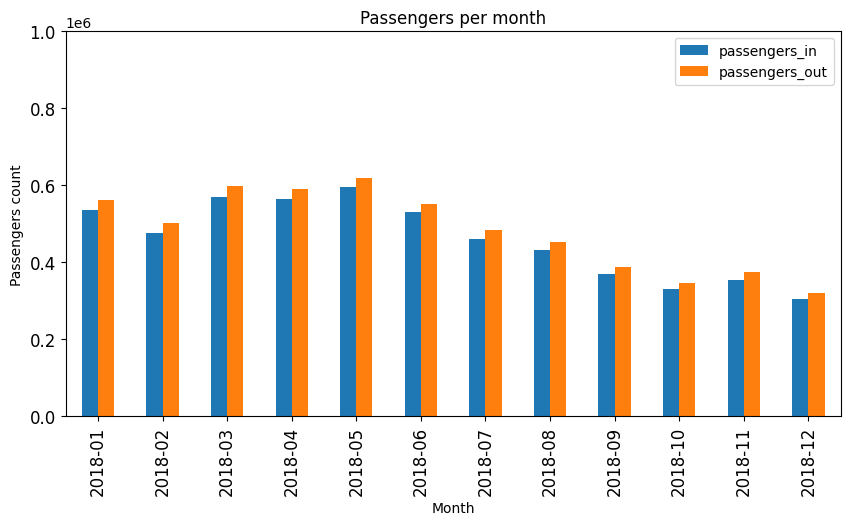

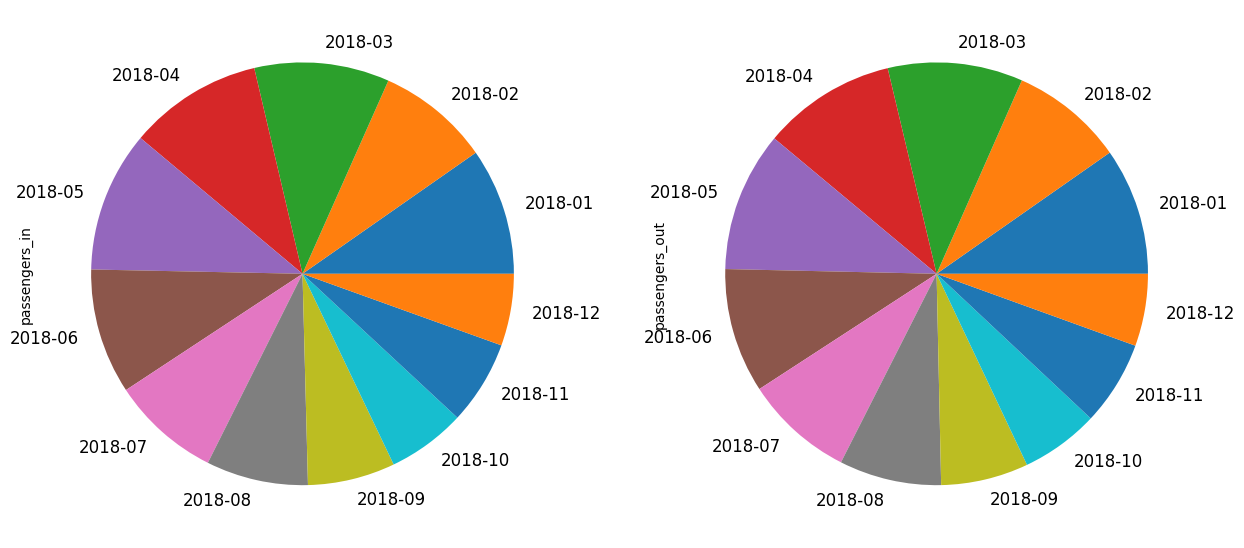

In [41]:
ax = traffic_by_month_df.plot(kind='bar',
                              figsize=(10, 5), 
                              fontsize=12)
ax.set_xlabel('Month')
ax.set_ylabel('Passengers count')
ax.set_title('Passengers per month')
ax.set_ylim(0, 1000000)

traffic_by_month_df.plot(kind='pie', 
                         subplots=True, 
                         figsize=(15, 8), 
                         fontsize=12,
                         legend=False)

plt.show()

Usage of Vilnius public transport rises till May, then it starts to decrease and increases only in Nov. Number of passengers in and out are different, it may be because automatic passengers counters that are using in buses are not accurate.

## Passengers IN/OUT heatmap

Lets plot passengers flow heatmaps. To do that i need group data by month and stop.

In [42]:
df.head()

,direction,line,stop_number,stop_name,passengers_in,passengers_out,Relat. fill. [%],lat,lng,datetime
0,AP-OLANDU-PARKO G.,74,2353,Respublikinė psichiatrijos ligoninė,0,0,0.00,54.69,25.42,2018-01-01 05:43:09
1,ANTAKALNIS-PARKO G.,18,2353,Respublikinė psichiatrijos ligoninė,0,5,2.33,54.69,25.42,2018-01-01 07:49:17
2,STOTIS-N.VILNIA,31,2353,Respublikinė psichiatrijos ligoninė,0,0,0.00,54.69,25.42,2018-01-01 09:16:06
3,STOTIS-PARKO G.,74,2353,Respublikinė psichiatrijos ligoninė,0,0,3.49,54.69,25.42,2018-01-01 09:30:04
4,ANTAKALNIS-PARKO G.,18,2353,Respublikinė psichiatrijos ligoninė,0,0,7.00,54.69,25.42,2018-01-01 11:06:09


In [43]:
traffic_by_stop_df = df.groupby([df['datetime'].dt.month, df['lat'], df['lng']])[['passengers_in', 
                                                                                 'passengers_out']].sum().reset_index()
traffic_by_stop_df = traffic_by_stop_df.rename(columns={'datetime': 'month'})
traffic_by_stop_df.head()

,month,lat,lng,passengers_in,passengers_out
0,1,54.58,25.20,1155,1850
1,1,54.58,25.20,35,183
2,1,54.58,25.21,113,37
3,1,54.59,25.21,4,42
4,1,54.59,25.21,34,10


Now lets check where passengers are traveling from every month.

In [44]:
map_vilnius = folium.Map(location=[54.685010, 25.274211], zoom_start = 11)
heat_data = [[[row['lat'], row['lng'], row['passengers_in']] for index, row in traffic_by_stop_df[traffic_by_stop_df['month'] == i].iterrows()] for i in range(1, 13)]

heatmap = folium_plugins.HeatMapWithTime(heat_data,
                                         index=['%s month' % i for i in range(1, 13)],
                                         min_opacity=0.15,
                                         max_opacity=0.7,
                                         scale_radius=False,
                                         use_local_extrema=True,
                                         radius=20)

map_vilnius.add_child(heatmap)
map_vilnius.save('attachments/in_heatmap.html')
map_vilnius

Now lets see where passengers are traveling to the most.

In [45]:
map_vilnius = folium.Map(location=[54.685010, 25.274211], zoom_start = 11)
heat_data = [[[row['lat'], row['lng'], row['passengers_out']] for index, row in traffic_by_stop_df[traffic_by_stop_df['month'] == i].iterrows()] for i in range(1, 13)]

heatmap = folium_plugins.HeatMapWithTime(heat_data,
                                         index=['%s month' % i for i in range(1, 13)],
                                         min_opacity=0.15,
                                         max_opacity=0.7,
                                         scale_radius=False,
                                         use_local_extrema=True,
                                         radius=20)

map_vilnius.add_child(heatmap)
map_vilnius.save('attachments/out_heatmap.html')
map_vilnius

Courses are the same as with TO data.

## Passengers flow by week day


It is interesting to inspect passengers traffic flow by week days over year and single month. At this point I am analyzing only count of passengers IN value.

In [48]:
passengers_by_weekday_year = df.groupby([
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum().reset_index()
passengers_by_weekday_year['weekday'] = passengers_by_weekday_year['weekday'] + 1
passengers_by_weekday_year

,weekday,passengers_in
0,1,909472
1,2,961189
2,3,916423
3,4,931062
4,5,898682
5,6,490239
6,7,418840


Text(0.5, 1.0, 'Over year')

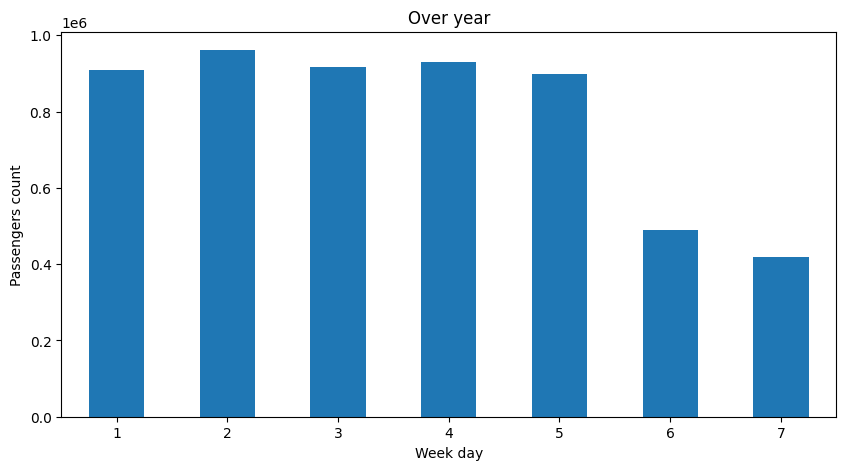

In [49]:
passengers_by_weekday_year = passengers_by_weekday_year.set_index('weekday')
ax = passengers_by_weekday_year['passengers_in'].plot(kind='bar', 
                                                      figsize=(10, 5), 
                                                      color='C0',
                                                      rot=0,
                                                      legend=False)
ax.set_xlabel('Week day')
ax.set_ylabel('Passengers count')
ax.set_title('Over year')

Passengers flow on weekends is about 45 % lower then on normal working day.

In [50]:
passengers_by_weekday = df.groupby([
    df['datetime'].dt.month.rename('month'), 
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum().reset_index()
passengers_by_weekday['weekday'] = passengers_by_weekday['weekday'] + 1
passengers_by_weekday

,month,weekday,passengers_in
0,1,1,91838
1,1,2,100806
2,1,3,96008
3,1,4,80980
4,1,5,82135
...,...,...,...
79,12,3,55604
80,12,4,54896
81,12,5,50136
82,12,6,21802


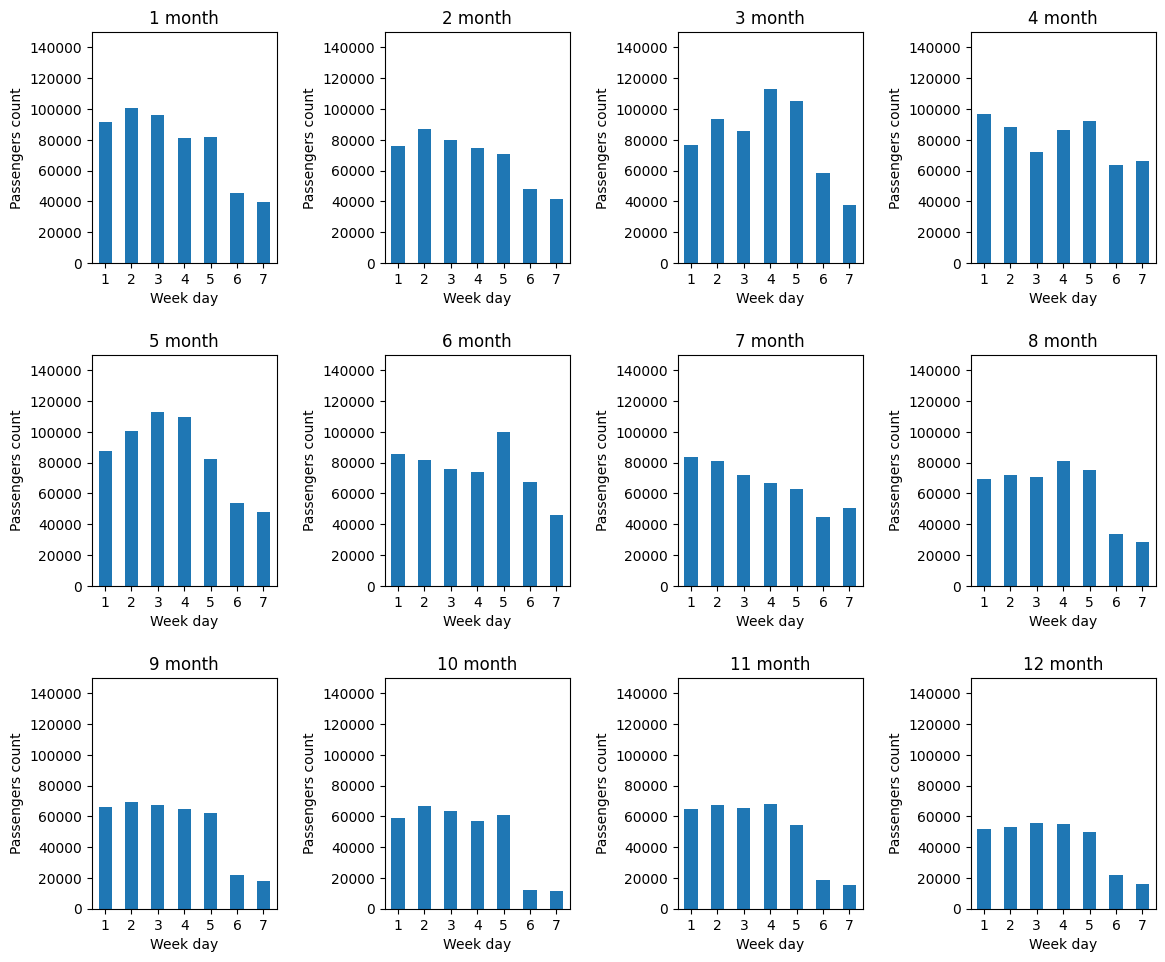

In [51]:
passengers_by_weekday = passengers_by_weekday.set_index('weekday')

fig, axes = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()

axes_list = [item for sublist in axes for item in sublist] 

for month_num in range(1, 13):
    ax = passengers_by_weekday[passengers_by_weekday['month'] == month_num][['passengers_in']].plot(kind='bar', 
                                                                                                    figsize=(12, 10), 
                                                                                                    ax=axes_list[month_num - 1], 
                                                                                                    rot=0,
                                                                                                    legend=False)
    ax.set_xlabel('Week day')
    ax.set_ylabel('Passengers count')
    ax.set_title('%s month' % str(month_num))
    ax.set_ylim(0,150000)

At summer time passengers flow decreases. the most busy day of the week also differs month by month

## Passengers flow by hours

I am interesting how passengers flow changes depending on time of the day over year and single month. At this point I am analyzing only count of passengers IN value. Hourly counts are grouped into to ranges of 4 hours.

In [52]:
passengers_by_hours_year = df.groupby([
    df['datetime'].dt.weekday.rename('weekday'),
    pd.cut(df['datetime'].dt.hour.rename('hour'), [0, 4, 8, 12, 16, 20, 24])])['passengers_in'].sum().reset_index()

passengers_by_hours_year['weekday'] = passengers_by_hours_year['weekday'] + 1
passengers_by_hours_year['weekday_name'] = passengers_by_hours_year['weekday'].apply(lambda x: calendar.day_name[x - 1])
passengers_by_hours_year = passengers_by_hours_year.set_index(['weekday_name', 'hour'])

passengers_by_hours_year

weekday  passengers_in
weekday_name hour                            
Monday       (0, 4]          1           1097
             (4, 8]          1         205814
             (8, 12]         1         185524
             (12, 16]        1         280101
             (16, 20]        1         201401
             (20, 24]        1          35430
Tuesday      (0, 4]          2           1120
             (4, 8]          2         216947
             (8, 12]         2         205224
             (12, 16]        2         292735
             (16, 20]        2         207529
             (20, 24]        2          37535
Wednesday    (0, 4]          3           1370
             (4, 8]          3         208714
             (8, 12]         3         191537
             (12, 16]        3         279045
             (16, 20]        3         198259
             (20, 24]        3          37344
Thursday     (0, 4]          4           1706
             (4, 8]          4         208694
             (8, 12]         4         197661
             (12, 16]        4         283614
             (16, 20]        4         200309
             (20, 24]        4          38812
Friday       (0, 4]          5           1299
             (4, 8]          5         199056
             (8, 12]         5         197956
             (12, 16]        5         284702
             (16, 20]        5         172282
             (20, 24]        5          43180
Saturday     (0, 4]          6           9174
             (4, 8]          6          64851
             (8, 12]         6         136064
             (12, 16]        6         139453
             (16, 20]        6         102097
             (20, 24]        6          32686
Sunday       (0, 4]          7           5617
             (4, 8]          7          47682
             (8, 12]         7         124803
             (12, 16]        7         121828
             (16, 20]        7          90057
             (20, 24]        7          24271

Text(0.5, 1.0, 'Over year')

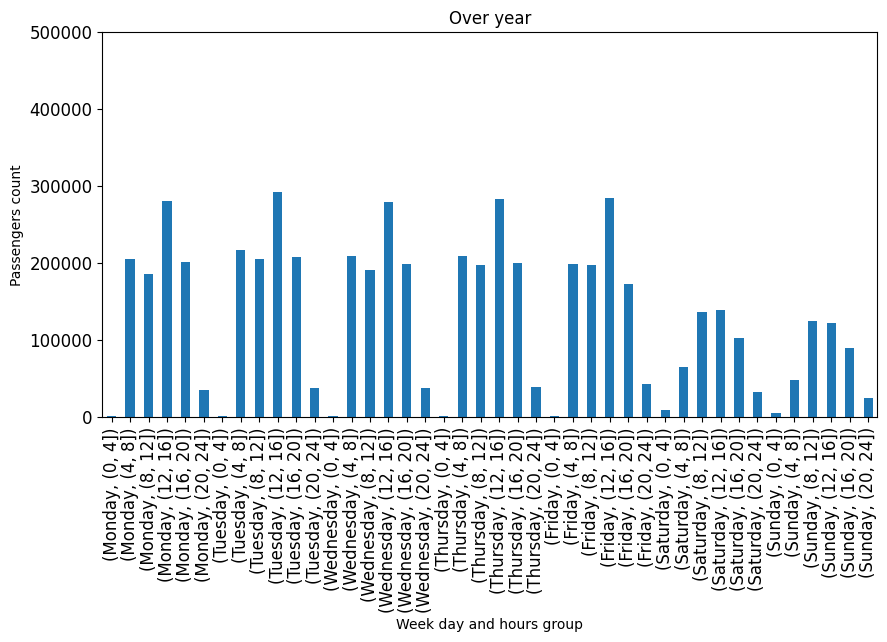

In [53]:
ax = passengers_by_hours_year['passengers_in'].plot(kind='bar', 
                                                    figsize=(10, 5), 
                                                    color='C0',
                                                    fontsize=12,
                                                    legend=False)
ax.set_ylim(0,500000)
ax.set_xlabel('Week day and hours group')
ax.set_ylabel('Passengers count')
ax.set_title('Over year')

In [54]:
passengers_by_hours = df.groupby([
    df['datetime'].dt.month.rename('month'), 
    df['datetime'].dt.weekday.rename('weekday'),
    pd.cut(df['datetime'].dt.hour.rename('hour'), [0, 4, 8, 12, 16, 20, 24])])['passengers_in'].sum().reset_index()

passengers_by_hours['weekday'] = passengers_by_hours['weekday'] + 1
passengers_by_hours['weekday_name'] = passengers_by_hours['weekday'].apply(lambda x: calendar.day_name[x - 1])

passengers_by_hours

,month,weekday,hour,passengers_in,weekday_name
0,1,1,"(0, 4]",79,Monday
1,1,1,"(4, 8]",19076,Monday
2,1,1,"(8, 12]",17975,Monday
3,1,1,"(12, 16]",31301,Monday
4,1,1,"(16, 20]",20053,Monday
...,...,...,...,...,...
499,12,7,"(4, 8]",1676,Sunday
500,12,7,"(8, 12]",5561,Sunday
501,12,7,"(12, 16]",4960,Sunday
502,12,7,"(16, 20]",2937,Sunday


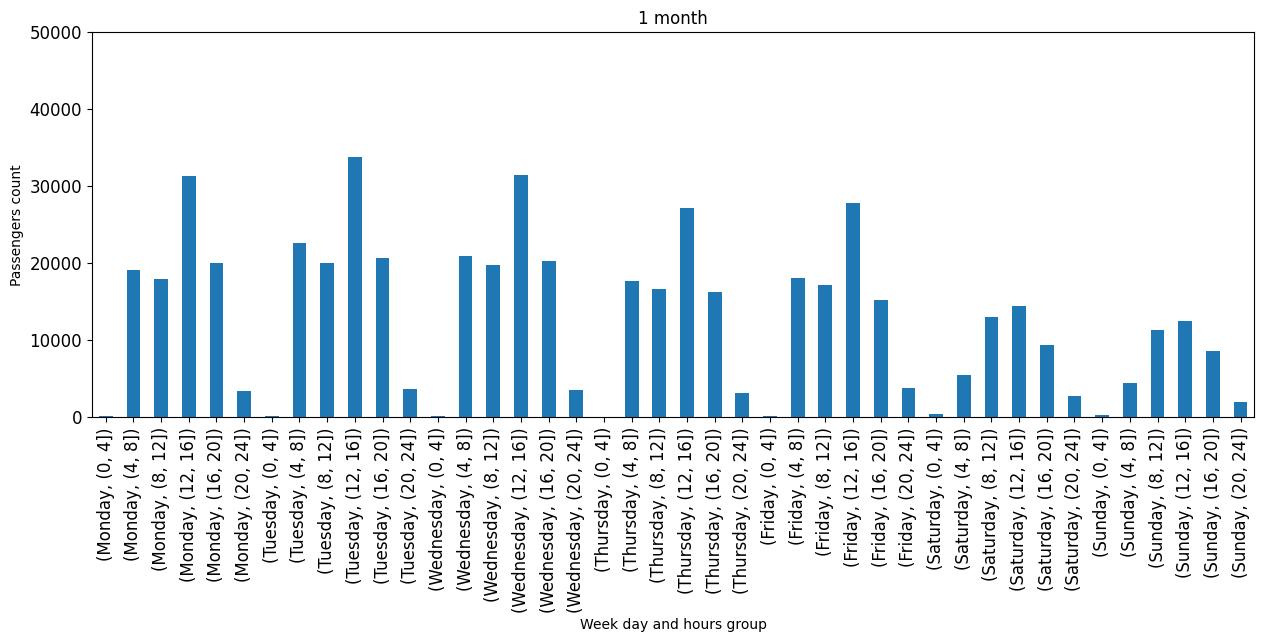

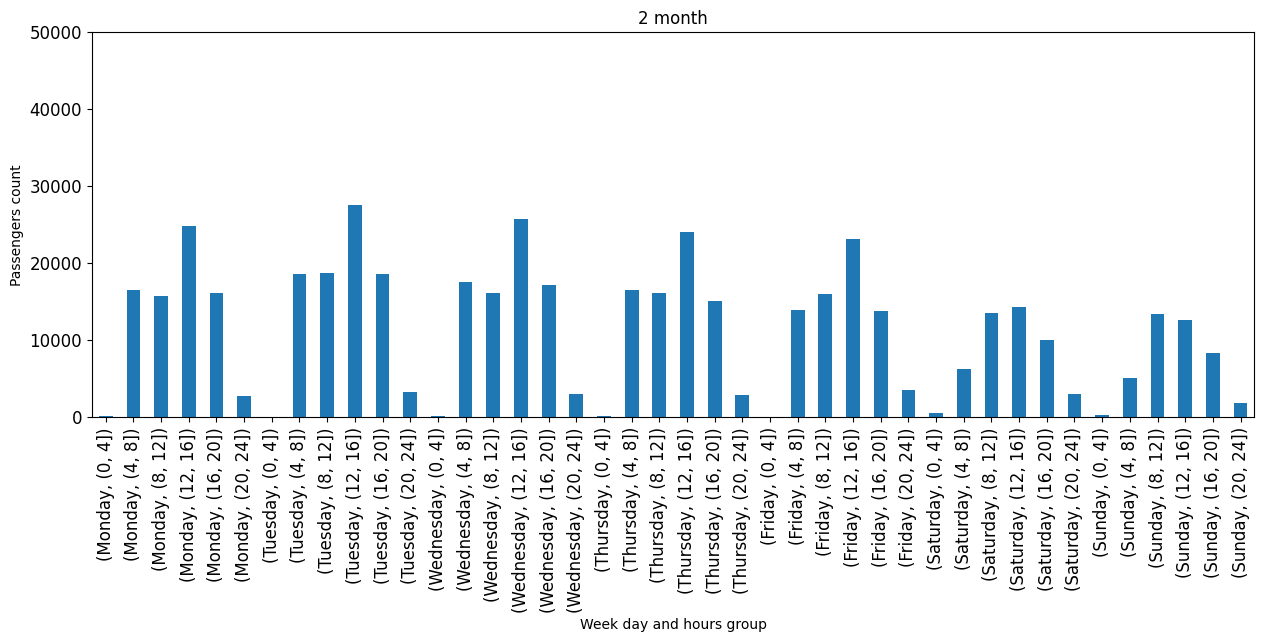

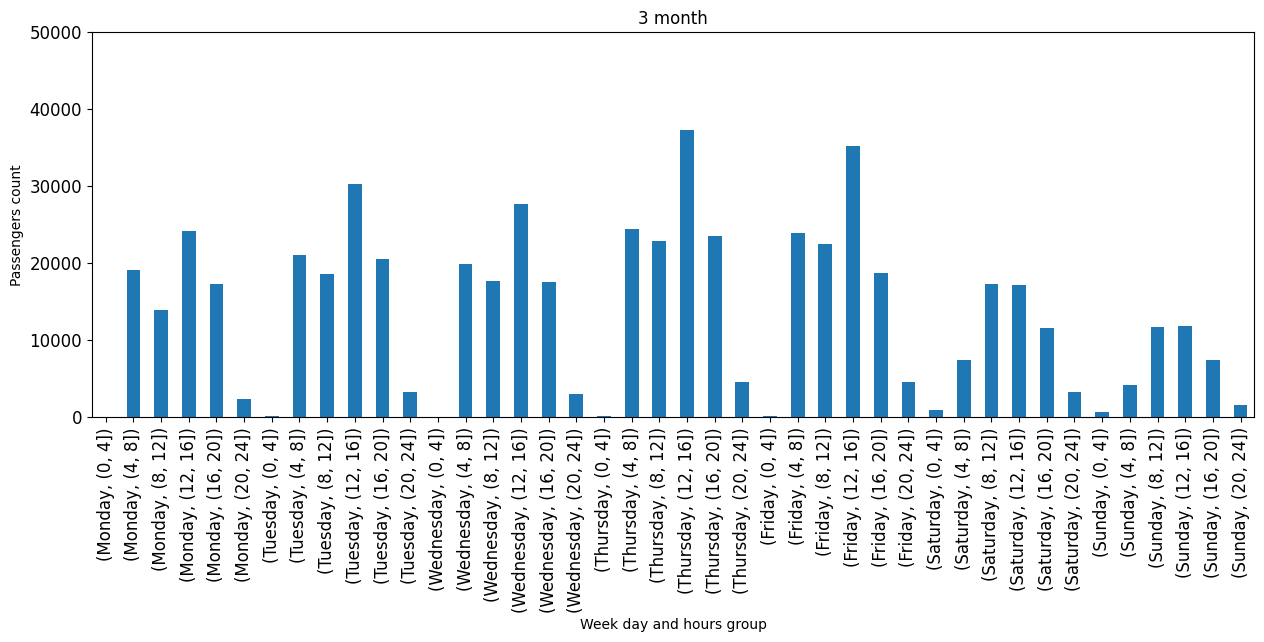

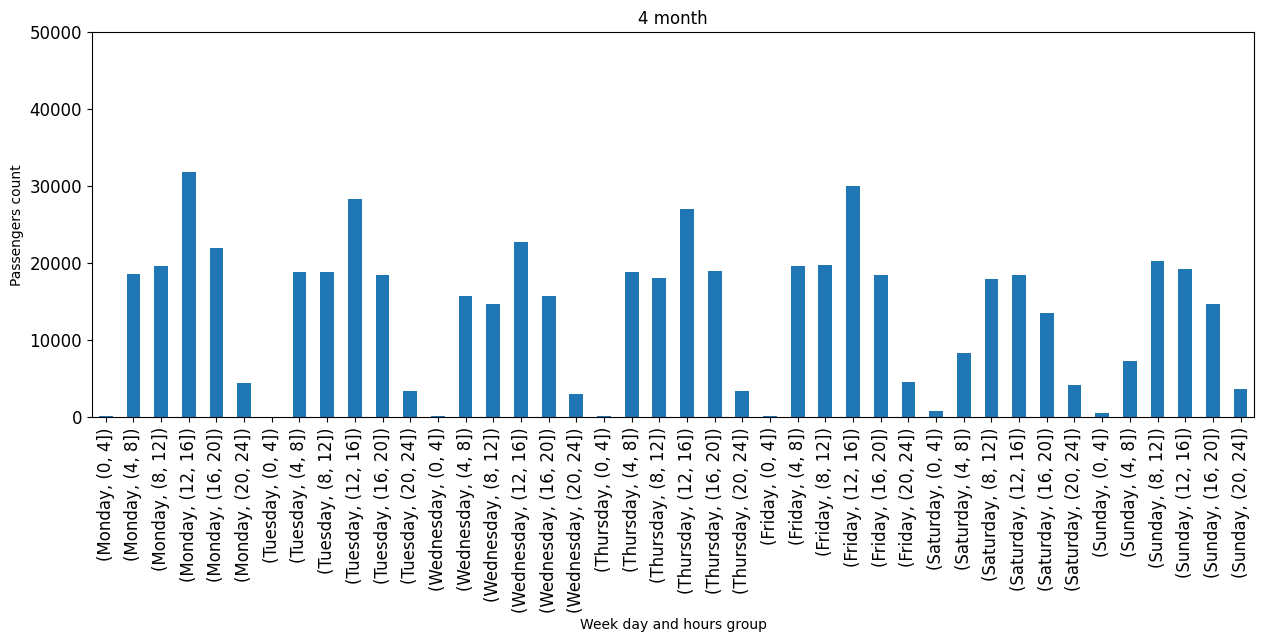

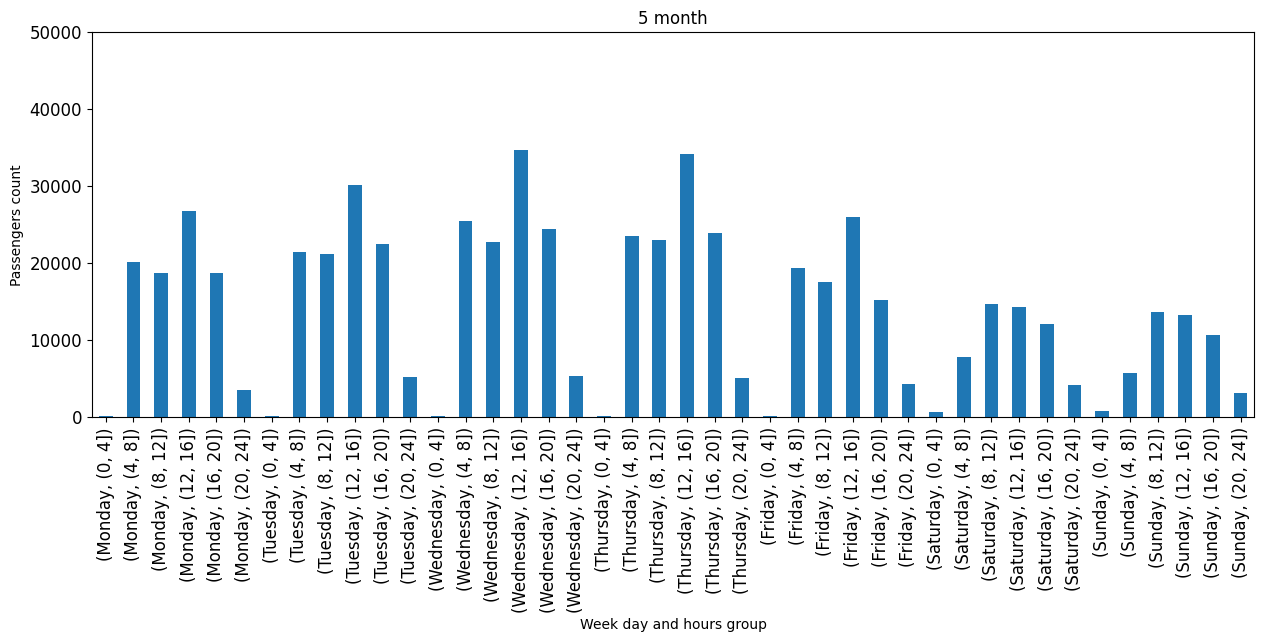

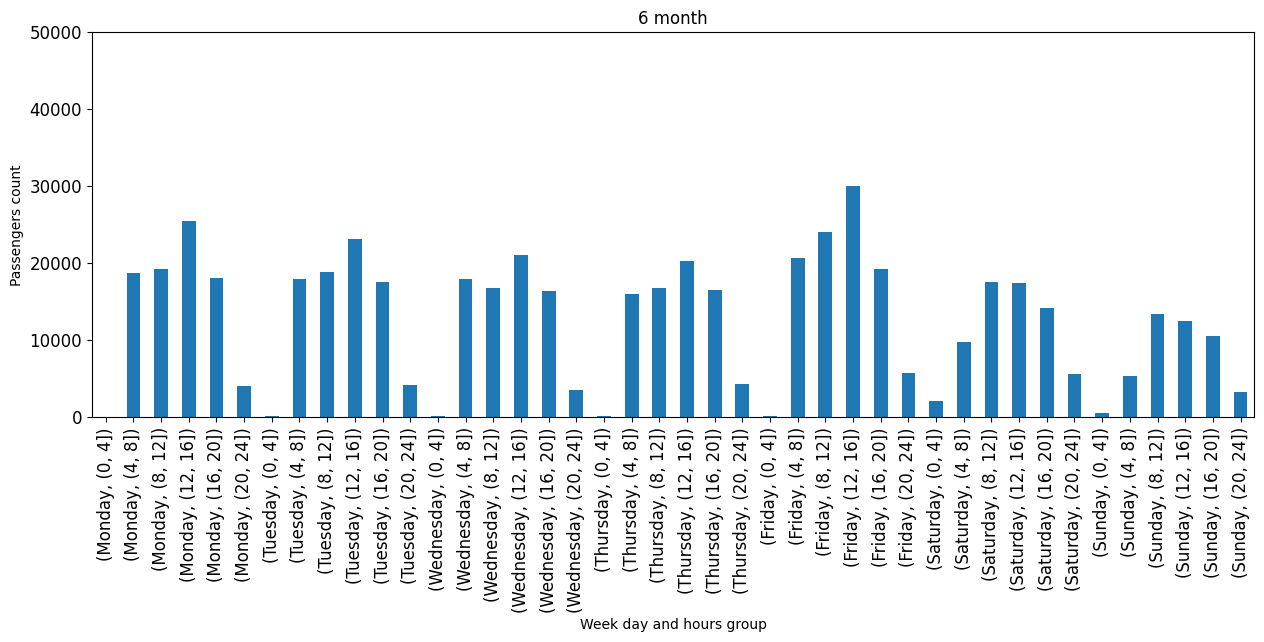

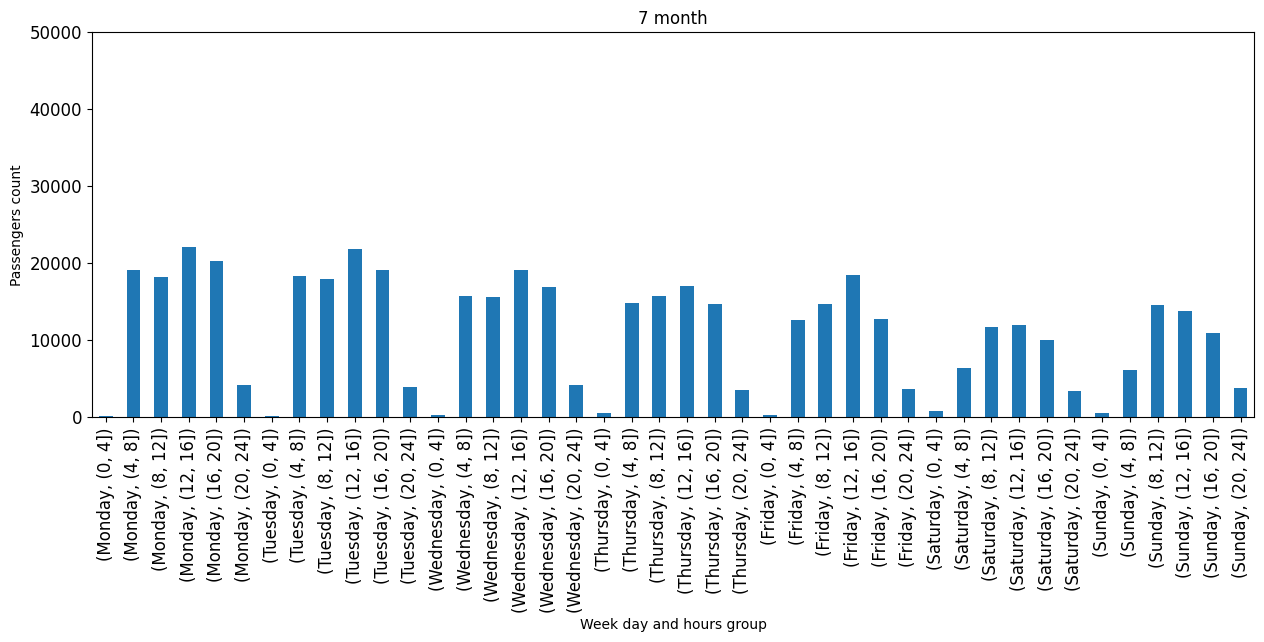

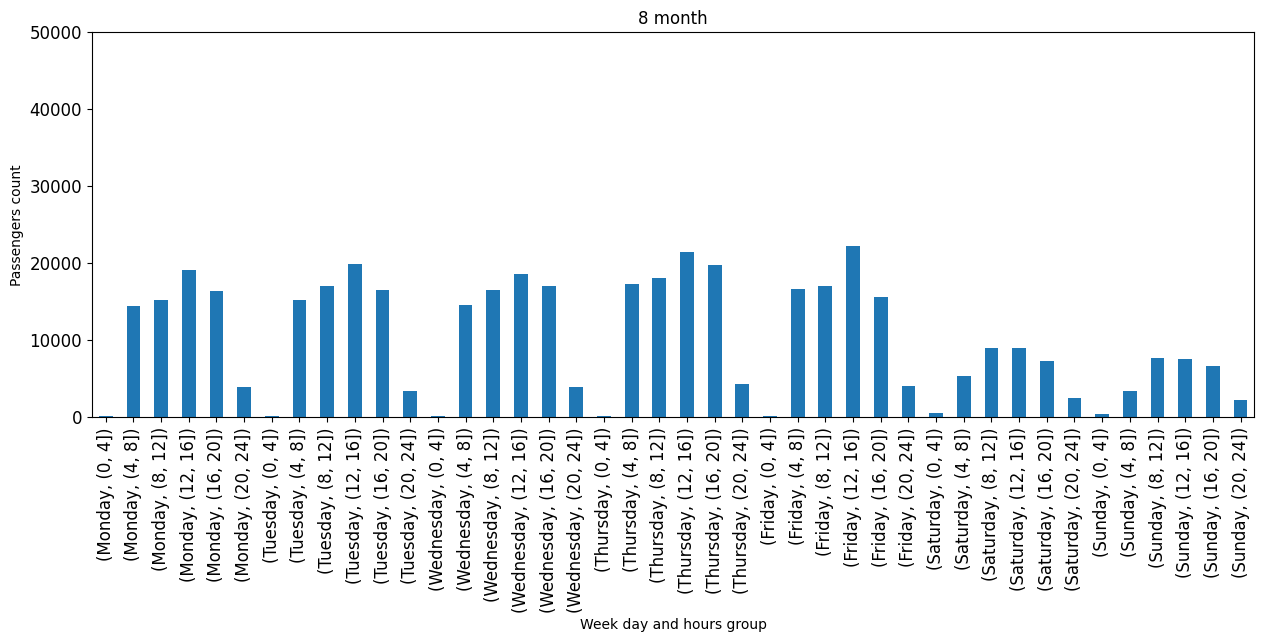

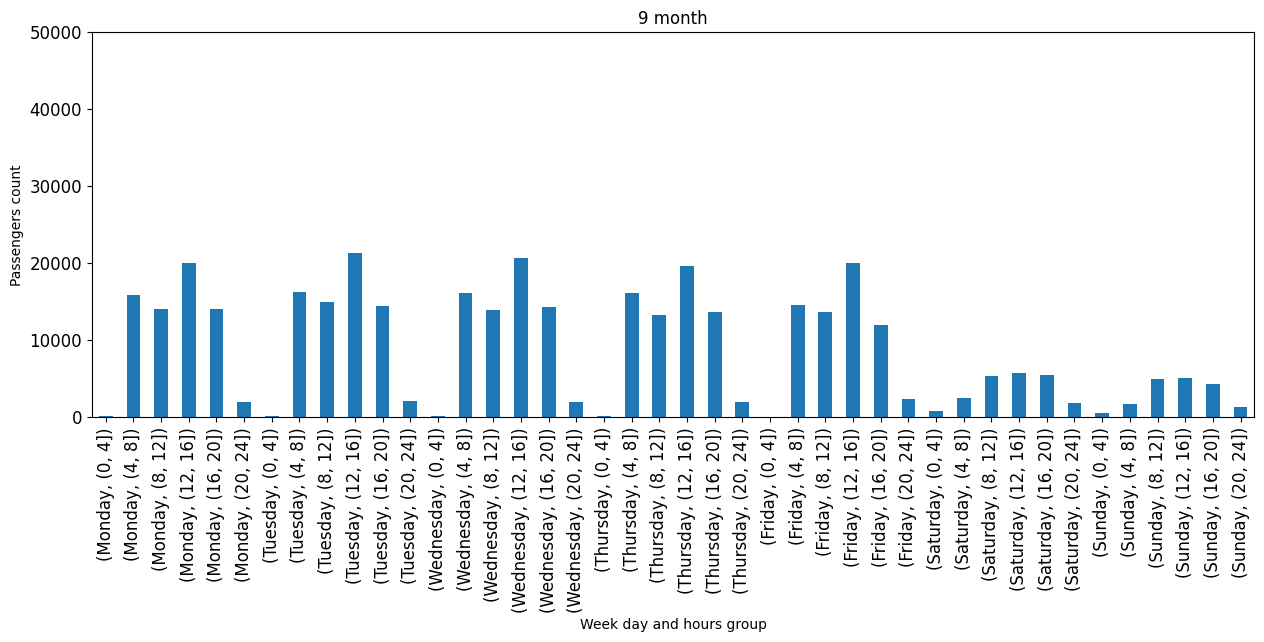

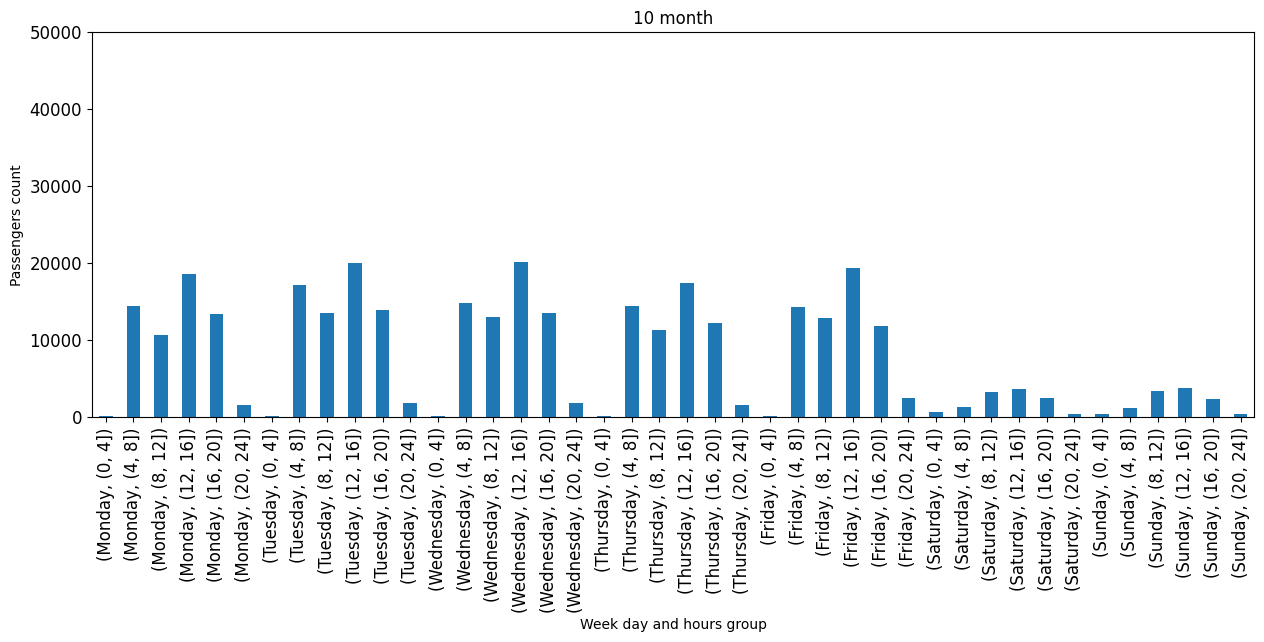

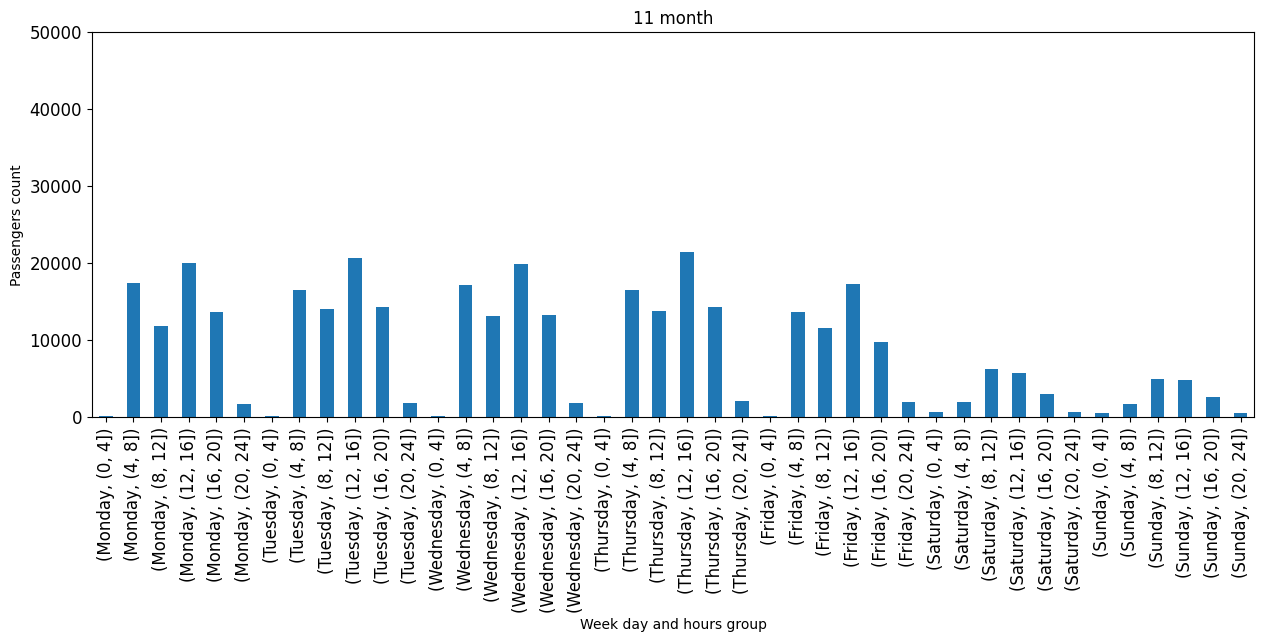

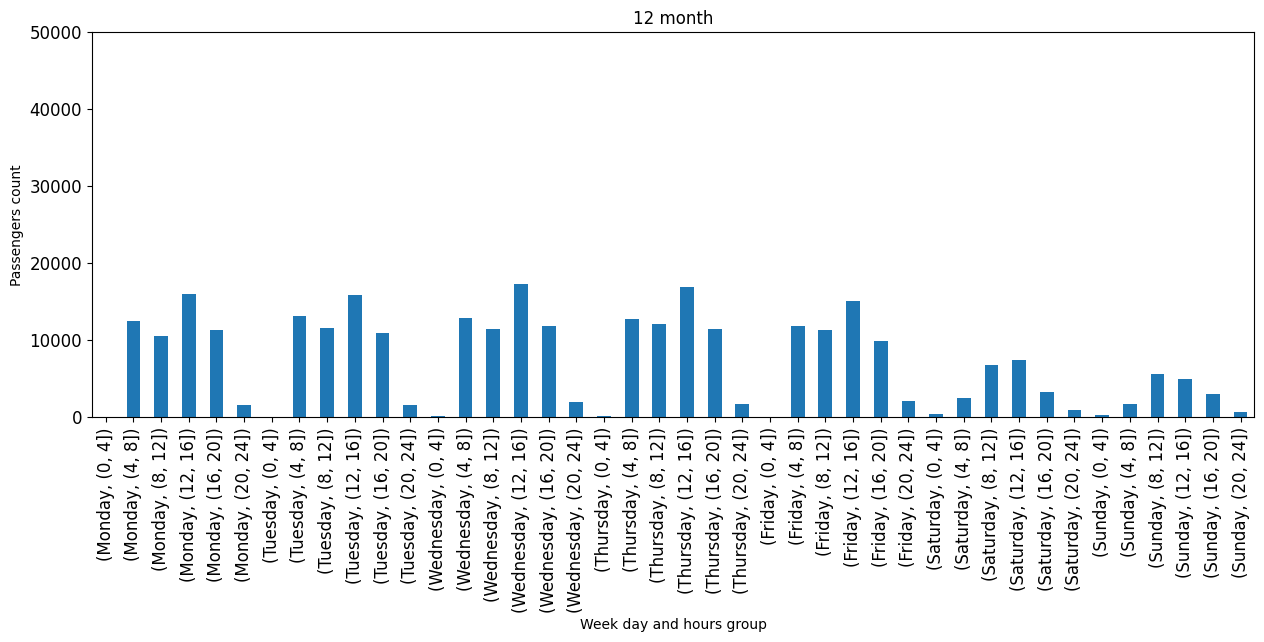

In [55]:
passengers_by_hours = passengers_by_hours.set_index(['weekday_name', 'hour'])

for month_num in range(1, 13):
    ax = passengers_by_hours[passengers_by_hours['month'] == month_num][['passengers_in']].plot(kind='bar', 
                                                                                                figsize=(15, 5), 
                                                                                                fontsize=12,
                                                                                                legend=False)
    ax.set_ylim(0,50000)
    ax.set_xlabel('Week day and hours group')
    ax.set_ylabel('Passengers count')
    ax.set_title('%s month' % str(month_num))

Highest passengers flow is between 12 and 16 hours. Least passengers flow is in the early morning. By the way biggest passengers traffic flow between 0 and 4 hours is on weekends, especially on saturdays. Passengers flow depends on the day of the week.

## Passengers flow correlation between month

Let's inspect which months are similar to each other based on passengers flow on week days.

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
0,91838,75972,76882,96532,87861,85594,83910,69217,66030,58784,64856,51996
1,100806,86764,93657,88027,100573,81599,81135,72201,69220,66698,67438,53071
2,96008,79590,85959,72098,112707,75760,71905,70745,67183,63498,65366,55604
3,80980,74734,112799,86352,109831,73961,66566,80941,64537,57078,68387,54896
4,82135,70455,104958,92539,82553,99788,62644,75573,62465,61043,54393,50136
5,45500,47894,58498,63577,54110,67516,44755,33982,21798,12085,18722,21802
6,39260,41721,37779,66199,47906,45814,50262,28282,18274,11732,15376,16235


<Axes: xlabel='month', ylabel='month'>

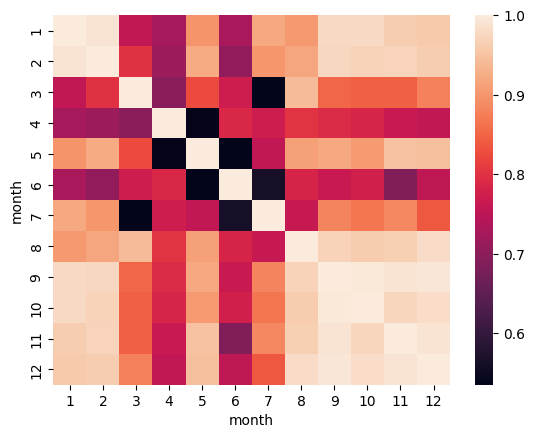

In [56]:
passengers_corr_month = df.groupby([
    df['datetime'].dt.month.rename('month'),
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum()

passengers_corr_month = passengers_corr_month.unstack(0)

display(passengers_corr_month)

corr = passengers_corr_month.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Correlation heatmap shows that 8-12 months passengers flow was very similar. On the other hand 3 and 7, 4 and 5, 5 and 6, 6 and 7 months passengers flow was different. 4 and 6 months flow differs from others

## Passengers flow trend

I guess no trend occurs in the data. Passengers flow rise and fall with no particular pattern, but lets test that.

<Axes: xlabel='dayofyear', ylabel='passengers_in'>

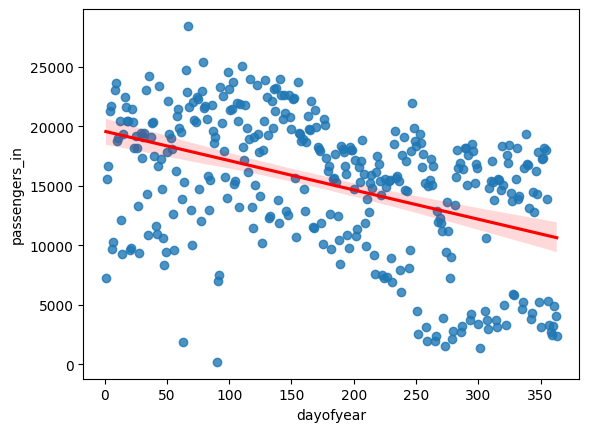

In [514]:
passengers_by_date = df.groupby([
    df['datetime'].dt.dayofyear.rename('dayofyear')])['passengers_in'].sum().reset_index()

sns.regplot(x='dayofyear', 
            y='passengers_in', 
            data=passengers_by_date,
            line_kws={'color': 'red'})

After performing linear regression analysis I can see that no linear trend exists. 

# Ticketing analysis

right now, you can buy 3 types of 1-way ticket in Vilnius: <30, <60 and 1-way without changing route. we will not discuss the last one, because it is the least popular and not connected to the time, when our goal is to find out time slots for 1-way tickets

Let's figure out whether we can try to predict the time travel based on data provided

In [88]:
df = df.sort_values(by='datetime')

In [91]:
stops_dict = pd.read_csv("data\\final_combined_matched_stops.csv")

here i wound out that mostly for each line there are usually 2 most popular directions (logically it should be like that)

In [40]:
direction_counts = df.groupby(['line', 'direction']).size().reset_index(name='counts')


top_two_directions = direction_counts.groupby('line').apply(lambda x: x.nlargest(2, 'counts')).reset_index(drop=True)


df = df.merge(top_two_directions[['line', 'direction']], on=['line', 'direction'], how='inner')
df.head(3)

,direction,line,stop_number,stop_name,passengers_in,passengers_out,lat,lng,datetime,Stop number,final_stop_id
0,S.MIESTELIS-PILAITE,30,0921,Povilo Lukšio st.,2,0,54.71,25.30,2018-01-01 05:37:19,0921,7589.00
1,S.MIESTELIS-PILAITE,30,0707,Giedraičių st.,2,0,54.71,25.28,2018-01-01 05:44:08,0707,5351.00
2,S.MIESTELIS-PILAITE,30,0705,Žalgirio st.,5,1,54.70,25.28,2018-01-01 05:46:58,0705,5467.00


In [42]:
df = df.rename(columns={'final_stop_id': 'Stop ID'})
df['Stop ID'] = df['Stop ID'].astype(int)

*there was a huge amount of unnesessary code after which i understood that there is no way i will determine each trip separately, because not on all stops the data was recorded by sensors (even when i won't delete the "error data")*

### New Hypothesis. 

Using Google Maps API I could get travel time for all of the routes from stop_A to stop_B, where stop_A and stop_B are all the stops I have. Then, based on the popularity of the route (passengers_in on the station A and passengers_out on the station B) I could add weights to the routes and find out travel times

In [ ]:
load_dotenv()

GOOGLE_MAPS_KEY = os.getenv("GOOGLE_MAPS_KEY")

In [ ]:
API_KEY = GOOGLE_MAPS_KEY

gmaps = googlemaps.Client(key=GOOGLE_MAPS_KEY)

In [ ]:
traffic_by_stop_df.head()

,stop_number,Stop ID,lat,lng,passengers_in,passengers_out
0,0101,5245,54.69,25.28,104191,61774
1,0102,5244,54.69,25.28,43789,87502
2,0103,753,54.70,25.28,15739,29514
3,0104,753,54.70,25.28,59113,27873
4,0105,6635,54.70,25.27,8231,15850


In [ ]:
traffic_by_stop_df = df.groupby(['stop_number', 'lat', 'lng'])[['passengers_in', 'passengers_out']].sum().reset_index()
traffic_by_stop_df.describe()

,stop_number,lat,lng,passengers_in,passengers_out
count,1034.00,1034.00,1034.00,1034.00,1034.00
mean,2331.67,54.70,25.28,5344.20,5594.21
std,1384.89,0.05,0.07,9315.81,9259.69
min,101.00,54.58,25.09,0.00,0.00
25%,1301.25,54.67,25.24,517.25,496.00
50%,2229.50,54.70,25.28,2167.00,2360.50
75%,3312.75,54.73,25.32,5852.00,6802.50
max,5206.00,54.83,25.44,105850.00,88472.00


to test i've taken the stops with more than 25 passengers_in and 25 passengers_out per day

In [ ]:
pop_stops_df = traffic_by_stop_df[(traffic_by_stop_df['passengers_in'] > 9125) & (traffic_by_stop_df['passengers_out'] > 9125)]

In [ ]:
traffic_by_stop_df['passengers_in'].sum()

5525907

In [ ]:
pop_stops_df['passengers_in'].sum()

2323168

In [ ]:
pop_stops_df.describe()

,stop_number,lat,lng,passengers_in,passengers_out
count,87.00,87.00,87.00,87.00,87.00
mean,1625.09,54.71,25.26,25629.08,26154.46
std,1150.33,0.03,0.03,16645.73,16672.33
min,101.00,54.58,25.20,10117.00,10129.00
25%,703.50,54.69,25.24,13507.50,14932.50
50%,1616.00,54.71,25.27,21069.00,19466.00
75%,2059.00,54.73,25.28,31563.00,32537.50
max,5114.00,54.78,25.36,105850.00,88472.00


In [ ]:
test_stops_df = pop_stops_df

In [ ]:
coordinates = test_stops_df[['lat', 'lng']].values

stop_ids = test_stops_df['stop_number'].tolist()
travel_times_df = pd.DataFrame(index=stop_ids, columns=stop_ids, dtype=float)

In [ ]:
departure_time = datetime(year=2024, month=8, day=14, hour=7, minute=20) 

In [ ]:
def transit_time(directions_result):
    steps = directions_result[0]['legs'][0]['steps']
    first_transit_index = None
    last_transit_index = None
    for step_index, step in enumerate(steps):
        if step['travel_mode'] == 'TRANSIT':
            if first_transit_index is None:
                first_transit_index = step_index
            last_transit_index = step_index
    if first_transit_index is None:
        return 0
    dep_time = datetime.utcfromtimestamp(steps[first_transit_index]['transit_details']['departure_time']['value'])
    arrival_time = datetime.utcfromtimestamp(steps[last_transit_index]['transit_details']['arrival_time']['value'])
    travel_time = (arrival_time - dep_time).total_seconds() / 60
    return travel_time

In [ ]:
def get_travel_time(origin, destination):
    result = gmaps.directions(origin, destination, mode="transit", departure_time=departure_time)
    if result:
        return transit_time(result)
    else:
        return np.nan

In [ ]:
for i, origin in enumerate(coordinates):
    for j, destination in enumerate(coordinates):
        if i != j:
            travel_time = get_travel_time(origin, destination)
            travel_times_df.at[stop_ids[i], stop_ids[j]] = travel_time
            print(f'{i}, {j}, {origin} to {destination}. Travel time: {travel_time}')
travel_times_df.to_csv('data/travel_time_demo.csv')

In [ ]:
pop_stops_df = pd.read_csv('data/pop_stops.csv')

In [ ]:
travel_times_df = pd.read_csv('data/travel_time_demo.csv')

In [ ]:
travel_times_df.set_index('Unnamed: 0')

,101,102,103,104,106,114,203,233,235,321,...,3331,3332,3801,3802,3805,3820,3821,3832,5103,5114
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
101,NaN,0.00,2.00,2.00,5.00,4.00,4.00,0.00,7.00,5.00,...,18.00,18.00,13.00,15.00,16.00,24.00,24.00,11.00,42.00,40.00
102,0.00,NaN,2.00,2.00,5.00,4.00,4.00,0.00,7.00,5.00,...,18.00,18.00,13.00,15.00,16.00,24.00,24.00,11.00,42.00,40.00
103,3.00,3.00,NaN,0.00,3.00,0.00,3.00,5.00,6.00,6.00,...,16.00,16.00,11.00,13.00,14.00,16.00,16.00,8.00,39.00,43.00
104,3.00,3.00,0.00,NaN,3.00,2.00,6.00,5.00,6.00,4.00,...,16.00,16.00,11.00,13.00,14.00,16.00,16.00,8.00,39.00,55.00
106,7.00,7.00,3.00,1.00,NaN,0.00,18.00,9.00,18.00,0.00,...,13.00,13.00,8.00,10.00,11.00,13.00,13.00,5.00,36.00,58.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,22.00,22.00,24.00,22.00,28.00,30.00,28.00,22.00,28.00,14.00,...,8.00,8.00,1.00,3.00,5.00,NaN,0.00,17.00,37.00,78.00
3821,22.00,22.00,24.00,22.00,21.00,30.00,28.00,22.00,28.00,14.00,...,8.00,8.00,1.00,3.38,5.00,0.00,NaN,9.00,37.00,81.00
3832,13.00,13.00,10.00,10.00,11.00,11.00,13.00,13.00,26.00,7.00,...,10.00,10.00,1.00,3.00,4.00,6.00,20.00,NaN,26.00,74.00


In [ ]:
x = travel_times_df < 30
x.sum().sum() / 93 ** 2

0.7836744132269626

so, 78.3% of the popular routes are less than 30 minutes

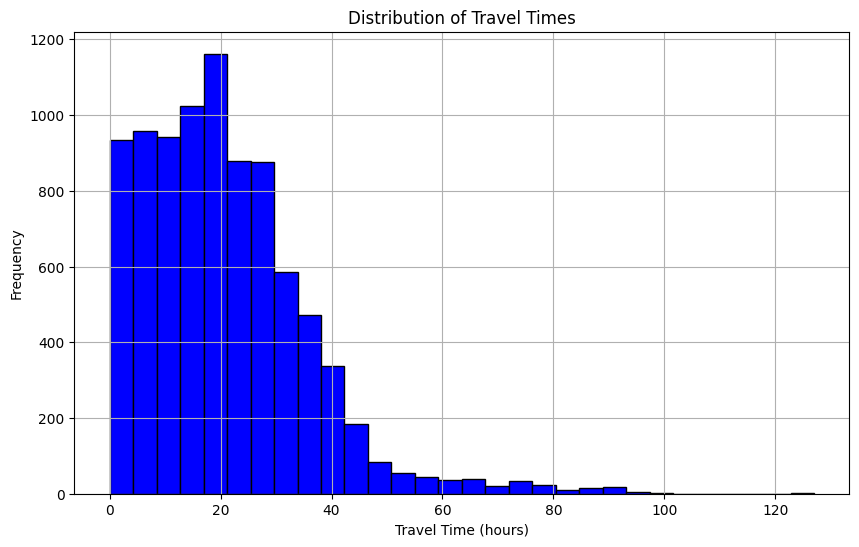

In [ ]:
travel_time_values = travel_times_df.set_index('Unnamed: 0').values.flatten()
travel_time_values = travel_time_values[~np.isnan(travel_time_values)]


plt.figure(figsize=(10, 6))
plt.hist(travel_time_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Travel Times')
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
travel_time_long = travel_times_df.melt(id_vars=['Unnamed: 0'], var_name='passenger_out', value_name='time_travel')
travel_time_long.rename(columns={'Unnamed: 0': 'passenger_in'}, inplace=True)


stops_mapping = pop_stops_df.set_index('stop_number')[['passengers_in', 'passengers_out']].to_dict()

travel_time_long['passenger_in'] = travel_time_long['passenger_in'].map(stops_mapping['passengers_in'])
travel_time_long['passenger_out'] = travel_time_long['passenger_out'].astype(int).map(stops_mapping['passengers_out'])


cleaned_travel_time = travel_time_long.dropna()

cleaned_travel_time.head()


,passenger_in,passenger_out,time_travel
1,44982,62352,0.00
2,15752,62352,3.00
3,59198,62352,3.00
4,25723,62352,7.00
5,11022,62352,5.00


In [ ]:
cleaned_travel_time = cleaned_travel_time[cleaned_travel_time['time_travel'] > 0]

In [ ]:
import numpy as np

cleaned_travel_time['total_weight'] = cleaned_travel_time['passenger_in'] + cleaned_travel_time['passenger_out']

weighted_mean = np.average(cleaned_travel_time['time_travel'], weights=cleaned_travel_time['total_weight'])


cleaned_travel_time_sorted = cleaned_travel_time.sort_values('time_travel')
cumulative_weight = np.cumsum(cleaned_travel_time_sorted['total_weight'])
midpoint = cumulative_weight.iloc[-1] / 2

weighted_median = cleaned_travel_time_sorted[cumulative_weight >= midpoint]['time_travel'].iloc[0]

weighted_mean, weighted_median


(20.376781966467778, 18.0)

In [ ]:
def weighted_percentile(data, weights, percentile):
    data_sorted = data.sort_values()
    cumulative_weights = np.cumsum(weights.loc[data_sorted.index])
    percentile_value = percentile / 100.0 * cumulative_weights.iloc[-1]
    return data_sorted[cumulative_weights >= percentile_value].iloc[0]



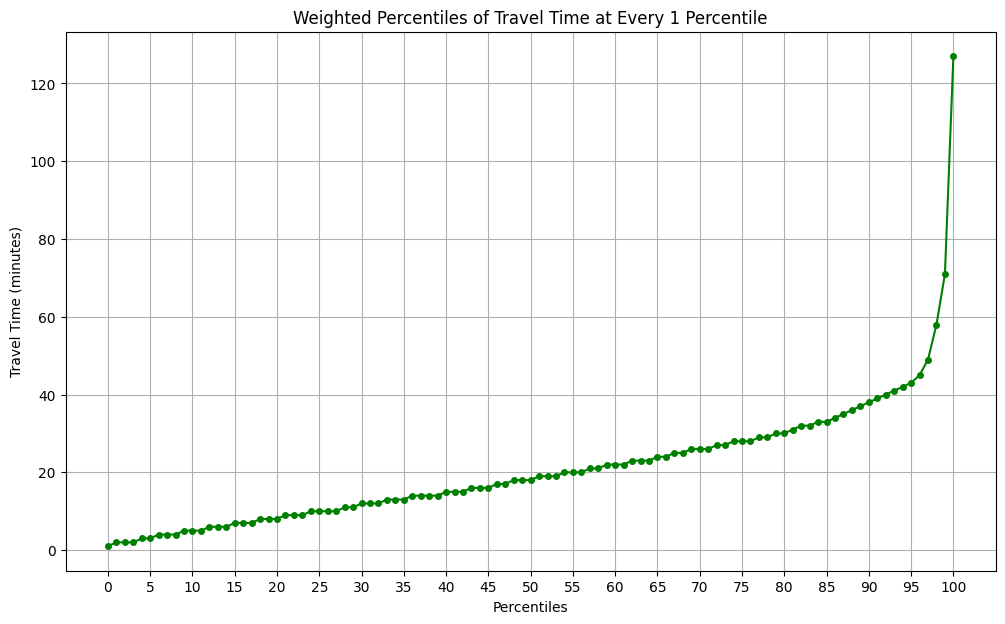

In [ ]:
percentile_range_fine = list(range(0, 101))

percentile_values_fine = [
    weighted_percentile(cleaned_travel_time['time_travel'], cleaned_travel_time['total_weight'], p)
    for p in percentile_range_fine
]

plt.figure(figsize=(12, 7))
plt.plot(percentile_range_fine, percentile_values_fine, marker='o', linestyle='-', color='g', markersize=4)
plt.title('Weighted Percentiles of Travel Time at Every 1 Percentile')
plt.xlabel('Percentiles')
plt.ylabel('Travel Time (minutes)')
plt.grid(True)
plt.xticks(range(0, 101, 5))
plt.show()


In [521]:
percentile_values_demand

,Unnamed: 0,0
0,0.00,1.00
1,1.00,1.00
2,2.00,1.00
3,3.00,1.00
4,4.00,1.16
...,...,...
96,96.00,36.00
97,97.00,38.37
98,98.00,41.86
99,99.00,47.67


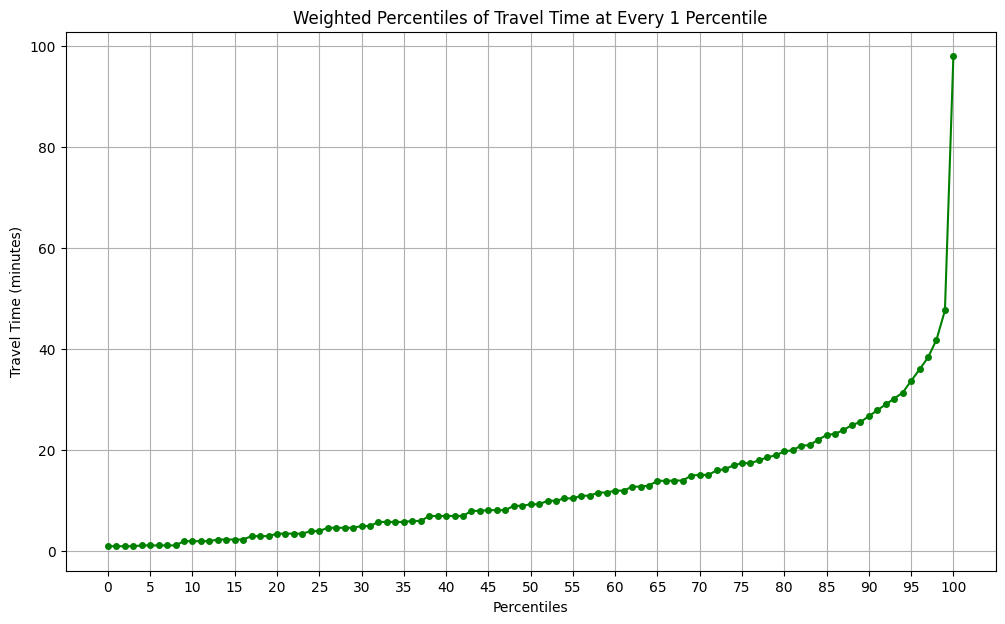

In [522]:
plt.figure(figsize=(12, 7))
plt.plot(percentile_values_demand['Unnamed: 0'], percentile_values_demand['0'], marker='o', linestyle='-', color='g', markersize=4)
plt.title('Weighted Percentiles of Travel Time at Every 1 Percentile')
plt.xlabel('Percentiles')
plt.ylabel('Travel Time (minutes)')
plt.grid(True)
plt.xticks(range(0, 101, 5))
plt.show()


In [ ]:
percentile_values_fine = pd.Series(percentile_values_fine)
percentile_values_fine.to_csv('data/percentile_values_fine.csv')

## finding out demand in the area

In [ ]:
from haversine import haversine

def find_nearby_stops(stop_row, all_stops, radius=0.5):
    current_stop_location = (stop_row['Lat'], stop_row['Lng'])
    nearby_stops = []
    for _, row in all_stops.iterrows():
        location = (row['Lat'], row['Lng'])
        if haversine(current_stop_location, location, unit='km') <= radius:
            nearby_stops.append(row['Stop number'])
    return nearby_stops

stops_dict['Nearby_Stops'] = stops_dict.apply(find_nearby_stops, axis=1, all_stops=stops_dict)
stops_dict.head()


In [ ]:
# stops_dict.to_csv('data//stops_dicts_with_average.csv')

In [ ]:
stops_dict = pd.read_csv('data//stops_dicts_with_average.csv')

In [ ]:
stops_dict['Stop number'] = stops_dict['Stop number'].astype(str)
df['stop_number'] = df['stop_number'].astype(str).str.zfill(4)
df = pd.merge(df, stops_dict[['Stop number', 'final_stop_id', 'Nearby_Stops', 'len_near']], left_on='stop_number', right_on='Stop number', how='left')

In [ ]:
len(df)

4008635

In [ ]:
df.to_csv('data//df_stop_merge.csv')

In [ ]:
test_df['datetime']

0    2018-01-01 00:00:04
1    2018-01-01 00:01:29
2    2018-01-01 00:02:06
3    2018-01-01 00:02:09
4    2018-01-01 00:02:41
             ...        
95   2018-01-01 05:51:00
96   2018-01-01 05:51:03
97   2018-01-01 05:51:29
98   2018-01-01 05:51:30
99   2018-01-01 05:51:58
Name: datetime, Length: 100, dtype: datetime64[ns]

In [ ]:
df = df.reset_index()
duplicates = df[df.duplicated('datetime', keep=False)]
duplicates.head()

,index,direction,line,stop_number,stop_name,passengers_in,passengers_out,lat,lng,datetime,Stop number,final_stop_id,Nearby_Stops,len_near
33,33,AP-SIAURES MIESTELIS,30,0923,Povilo Lukšio st.,0,1,54.71,25.30,2018-01-01 05:34:51,0923,15167.00,"['0901', '0902', '0921', '0922', '0924', '0925...",7
34,34,AP-OLANDU-PARKO G.,74,0439,Vasaros st.,0,0,54.69,25.30,2018-01-01 05:34:51,0439,6565.00,"['0401', '0402', '0438', '0439', '1101', '1102...",8
76,76,AP-OZO-PASILAICIAI,46,2016,Licėjus,0,0,54.71,25.28,2018-01-01 05:46:02,2016,8463.00,"['0825', '0827', '2016', '0710', '0826']",5
77,77,AP-ANTAKALNIS-PARKO,18,1003,Gedimino technikos universitetas,0,0,54.72,25.34,2018-01-01 05:46:02,1003,5107.00,"['1002', '1003', '1004', '1005', '1022', '1023...",8
118,118,STOTIS-JUODSILIAI,82,1305,Stadionas,0,0,54.67,25.30,2018-01-01 05:55:31,1305,5944.00,"['1304', '1305', '1306', '1307', '1317', '1512']",6


In [ ]:
def adjust_datetime(dup_group):
    return dup_group + pd.to_timedelta(range(len(dup_group)), unit='ms')

df['datetime'] = df.groupby('datetime')['datetime'].transform(adjust_datetime)

In [ ]:
df.to_csv('data//df_stop_merge.csv')

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

unique_stops = df['stop_number'].unique()

subtable_averages = {}
subtable_counts = {}

for stop in unique_stops:
    relevant_stops = df[df['Nearby_Stops'].apply(lambda x: stop in x)]
    if relevant_stops.empty:
        continue
    
    rolling_stats = relevant_stops['passengers_in'].rolling('15T', closed='left').agg(['mean', 'count'])
    
    subtable_averages[stop] = rolling_stats['mean']
    subtable_counts[stop] = rolling_stats['count']

def get_relevant_stats(row):
    stop = row['stop_number']
    if stop in subtable_averages and row.name in subtable_averages[stop]:
        return subtable_averages[stop][row.name], subtable_counts[stop][row.name]
    return 0, 0

df['stats'] = df.apply(get_relevant_stats, axis=1)
df['avg_passengers_in_nearby_15_min'] = df['stats'].apply(lambda x: x[0])
df['count_passengers_in_nearby_15_min'] = df['stats'].apply(lambda x: x[1])
df.drop('stats', axis=1, inplace=True)  

df.reset_index()[['datetime', 'stop_name', 'Nearby_Stops', 'avg_passengers_in_nearby_15_min', 'count_passengers_in_nearby_15_min']].head()


,datetime,stop_name,Nearby_Stops,avg_passengers_in_nearby_15_min,count_passengers_in_nearby_15_min
0,2018-01-01 00:00:04,Pramogų arena,"['0708', '0709', '0802', '0803', '0804', '0805...",NaN,NaN
1,2018-01-01 00:01:29,Broniaus Laurinavičiaus skveras,"['0704', '0705', '0706', '0707', '0711', '0913...",NaN,NaN
2,2018-01-01 00:02:06,Verkių st.,"['0806', '0807', '0808', '0813', '0823', '5177...",NaN,NaN
3,2018-01-01 00:02:09,Gervėčių st.,"['0417', '0418', '0419', '0420', '0421', '0443...",NaN,NaN
4,2018-01-01 00:02:41,Giedraičių st.,"['0706', '0707', '0708', '0803', '0914', '0915...",0.00,1.00


In [ ]:
df.to_csv('data//df_avg_pass.csv')

In [ ]:
df['avg_passengers_in_nearby_15_min'] = df['avg_passengers_in_nearby_15_min'].fillna(0)
df['count_passengers_in_nearby_15_min'] = df['count_passengers_in_nearby_15_min'].fillna(0)

In [ ]:
df = pd.read_csv('data/df_with_demand.csv')

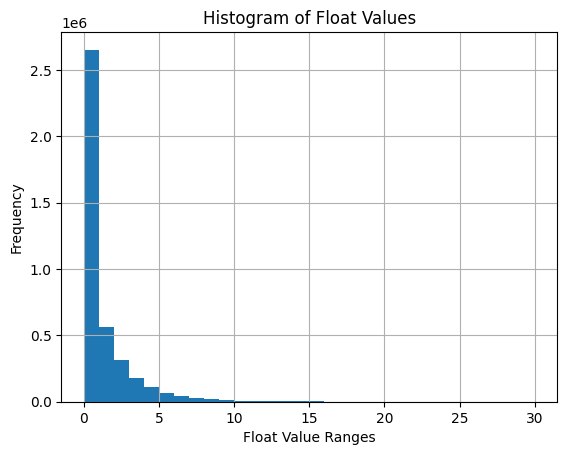

In [ ]:
df['avg_passengers_in_nearby_15_min'].hist(bins=30)

plt.title('Histogram of Float Values')
plt.xlabel('Float Value Ranges')
plt.ylabel('Frequency')

plt.show()

In [ ]:
df.to_csv('data//df_with_demand.csv')

In [ ]:
test_df.to_csv('data/df_demand_test.csv')

In [ ]:
stop_times_dict = {}

for idx, row in df.iterrows():
    for stop in row['Nearby_Stops']:
        if stop not in stop_times_dict:
            stop_times_dict[stop] = []
        stop_times_dict[stop].append((row['datetime'], row['passengers_in']))


In [ ]:
routes_df = pd.read_csv("data\\vilnius_route_stops_ordered_with_ids.csv")

# demand-based pricing

hypothesis: prices could be calculated not just by travel time slot, but individual for each travel time. that might help to reduce the amount of passengers in a peak time to motivate them use the public transport in off-peak hours. basic calculation of the new formula should be like that: $base price + a*demand + b*traveltime$

Our goal is to save the median price on the same level ($0.65*0.8+0.9*0.2$) and make the difference in percentiles the same from median (if travel time in percentiles is more than mean on x than the pricee should be more than 0.7 on the same level as it is less from time travel x less). So, difference from the median is a module distribution. Let's create a formula:

$$f(t) =  1 + K * \text{sign}(t - t_0) * \left( 1 - e^{-\left( \frac{|t - t_0|}{\mu} \right)^2} \right) $$



In [515]:
from sympy import symbols, Eq, solve, sqrt, exp

k = symbols('k')

t0 = 1
sigma = (1 - sqrt(0.025)) / 2
C1 = 2 / (sqrt(2) + 1)
C2 = sqrt(2) * 2 / (sqrt(2) + 1)
eq1 = Eq(1 - k * (1 - exp(-(2 * abs(0.5 - t0) / (1 - sqrt(0.025))) ** 2)), C1)
eq2 = Eq(1 + k * (1 - exp(-(2 * abs(1.5 - t0) / (1 - sqrt(0.025))) ** 2)), C2)

solution_k = solve((eq1, eq2), k)
solution_k


{k: 0.226926027646393}

In [243]:
percentile_values_fine = pd.read_csv('data/percentile_values_fine.csv')

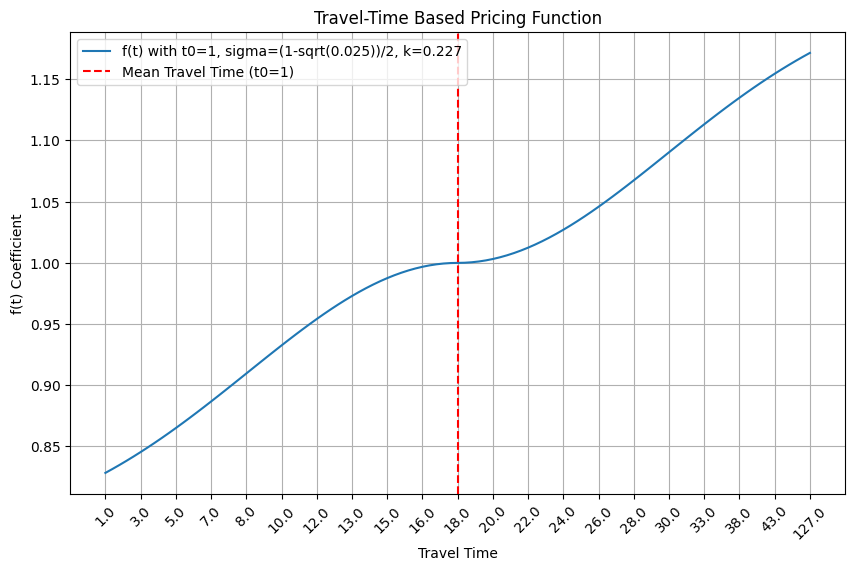

In [245]:
t = percentile_values_fine['Unnamed: 0'] / 100 + 0.5

f_t = 1 + k_value * np.sign(t - t0) * (1 - np.exp(-((2 * np.abs(t - t0)) / (1 - np.sqrt(0.025))) ** 2))

plt.figure(figsize=(10, 6))
plt.plot(t, f_t, label=f'f(t) with t0=1, sigma=(1-sqrt(0.025))/2, k={k_value:.3f}')
plt.title('Travel-Time Based Pricing Function')

plt.xticks(t[::5], labels=percentile_values_fine['0'][::5], rotation=45)

plt.xlabel('Travel Time')
plt.ylabel('f(t) Coefficient')
plt.axvline(x=t0, color='r', linestyle='--', label=f'Mean Travel Time (t0={t0})')
plt.legend()
plt.grid(True)
plt.show()


In [163]:
df = df[df['Relat. fill. [%]'] > 0]

In [248]:
percentile_values_demand = pd.Series(df['Relat. fill. [%]']).quantile([x / 100 for x in range(0, 101)])

In [251]:
percentile_values_demand.to_csv('data/percentile_values_demand.csv')


In [252]:
percentile_values_demand = pd.read_csv('data/percentile_values_demand.csv')


In [ ]:
percentile_values_demand = percentile_values_demand.rename(columns={'Relat. fill. [%]':'0'})
percentile_values_demand['Unnamed: 0'] = percentile_values_demand['Unnamed: 0']*100

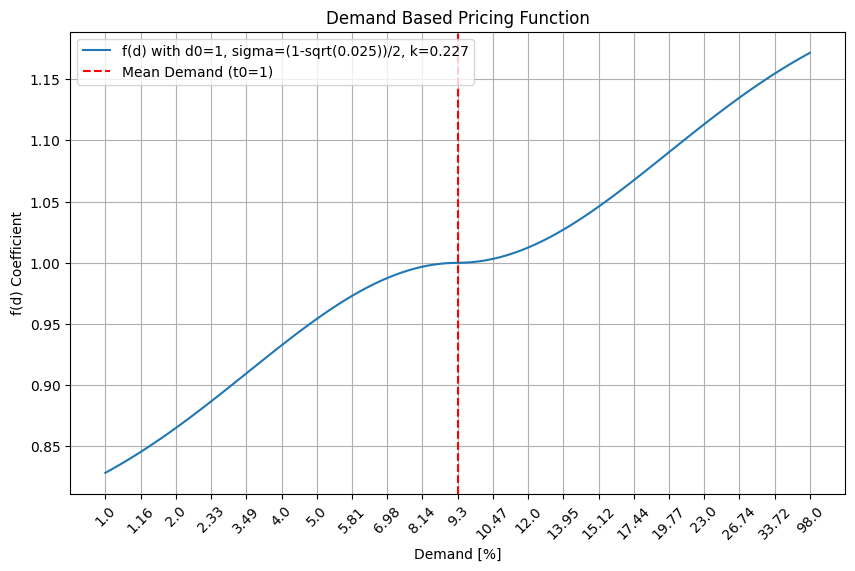

In [297]:
d0 = 1
d = percentile_values_demand['Unnamed: 0'] / 100 + 0.5
f_d = 1 + k_value * np.sign(d - d0) * (1 - np.exp(-((2 * np.abs(d - d0)) / (1 - np.sqrt(0.025))) ** 2))

plt.figure(figsize=(10, 6))
plt.plot(d, f_d, label=f'f(d) with d0=1, sigma=(1-sqrt(0.025))/2, k={k_value:.3f}')
plt.title('Demand Based Pricing Function')

plt.xticks(d[::5], labels=percentile_values_demand['0'][::5], rotation=45)

plt.xlabel('Demand [%]')
plt.ylabel('f(d) Coefficient')
plt.axvline(x=d0, color='r', linestyle='--', label=f'Mean Demand (t0={d0})')
plt.legend()
plt.grid(True)
plt.show()


In [300]:
import pandas as pd

def transform_to_coef(data, value, scale_factor=100, offset=0.5):

    filtered_data = data[data['0'] <= value]
    
    if not filtered_data.empty:
        closest_value = filtered_data.iloc[-1]['0']
        corresponding_value = filtered_data.loc[filtered_data['0'] == closest_value, 'Unnamed: 0'].values[-1]
        t_value = corresponding_value / scale_factor + offset
        return t_value
    else:
        return None


travel_time = 10
t_value = transform_to_coef(percentile_values_demand, travel_time)

if t_value is not None:
    print(f"t_value")
else:
    print("travel_time is not correct")


The transformed t value for travel time 10 is 1.03


In [447]:
travel_time = 60
demand = 40

def price_calculation(travel_time, demand):
    t = transform_to_coef(percentile_values_fine, travel_time)
    d = transform_to_coef(percentile_values_demand, demand)
    f_t = 1 + k_value * np.sign(t - t0) * (1 - np.exp(-((2 * np.abs(t - t0)) / (1 - np.sqrt(0.025))) ** 2))
    f_d = 1 + k_value * np.sign(d - d0) * (1 - np.exp(-((2 * np.abs(d - d0)) / (1 - np.sqrt(0.025))) ** 2))
    final_price = 0.7*f_t*f_d
    return final_price
print(round(price_calculation(travel_time, demand), 2))

0.95


### marketing



In [481]:
all_pass = df['passengers_in'].sum()
ticket_30 = 0.65
ticket_120 = 0.9
part_30 = (percentile_values_fine[percentile_values_fine['0'] == 30].iloc[-1]['Unnamed: 0']) / 100
total_money = round(all_pass *(part_30 * ticket_30 + (1-part_30) * ticket_120), 2)
total_money

3801737.8

In [509]:
df.columns

Index(['direction', 'line', 'stop_number', 'stop_name', 'passengers_in',
       'passengers_out', 'Relat. fill. [%]', 'lat', 'lng', 'datetime',
       '15_min_interval', 'weekday'],
      dtype='object')

In [507]:
all_pass = df['passengers_in'].sum()
ticket_20 = 0.6
ticket_120 = 0.8
part_20 = (percentile_values_fine[percentile_values_fine['0'] == 20].iloc[-1]['Unnamed: 0']) / 100
total_money_2 = round(all_pass *(part_20 * ticket_20 + (1-part_20) * ticket_120), 2)
total_money_2

3736565.15

In [479]:
part_30 * ticket_30 + (1-part_30) * ticket_120

0.7

In [353]:
weights = stops_mapping['passengers_out']

In [358]:
weights = pd.DataFrame(list(weights.items()), columns=['stop_number', 'weight'])

In [359]:
weights.to_csv('data/weights_tt.csv')

In [466]:
df_short = df[['stop_number', 'datetime', 'passengers_in', 'Relat. fill. [%]']]

In [467]:
weights_sum = weights['weight'].sum()
weights['probability'] = weights['weight'] / weights_sum

stop_to_prob = dict(zip(weights['stop_number'], weights['probability']))
stop_list = list(travel_times_df['Unnamed: 0'])
def choose_stop_out():
    return np.random.choice(weights['stop_number'], p=weights['probability'])

In [ ]:
def assign_stop_out_and_time(row):
    stop_in = row['stop_number']
    
    if stop_in not in stop_list:
        return pd.Series({'stop_out': np.nan, 'travel_time': 18})
    
    stop_out = choose_stop_out()
    
    try:
        travel_time = travel_times_df.loc[travel_times_df['Unnamed: 0'] == stop_in, str(stop_out)].values[0]
    except IndexError:
        travel_time = 18  
    if travel_time == 0:
        travel_time = 18
    return pd.Series({'stop_out': stop_out, 'travel_time': travel_time})

df_short[['stop_out', 'travel_time']] = df_short.apply(assign_stop_out_and_time, axis=1)

In [469]:
x = df_short

In [ ]:
df_short['travel_time'] = df_short['travel_time'].fillna(18)

In [ ]:
df_short['price'] = df_short.apply(lambda row: price_calculation(row['travel_time'], row['Relat. fill. [%]']), axis=1)

In [473]:
df_short.to_csv('data/df_short.csv')

In [472]:
df_short.describe()

,stop_number,datetime,passengers_in,Relat. fill. [%],stop_out,travel_time,price
count,3120282.00,3120282,3120282.00,3120282.00,811451.00,3120282.00,3120282.00
mean,2149.73,2018-06-13 14:20:40.661180672,1.74,12.20,1470.78,18.27,0.70
min,101.00,2018-01-01 05:29:09,0.00,1.00,101.00,1.00,0.49
25%,1026.00,2018-03-22 16:59:49.249999872,0.00,4.00,603.00,18.00,0.65
50%,2014.00,2018-06-07 23:09:05,0.00,9.30,1118.00,18.00,0.70
75%,2904.00,2018-08-26 16:25:11.500000,2.00,17.44,2010.00,18.00,0.75
max,5206.00,2018-12-29 23:17:25,30.00,98.00,5114.00,127.00,0.96
std,1354.81,NaN,3.00,10.57,1125.57,6.33,0.07


In [ ]:
df_short['final_price'] = df_short['passengers_in'] * df_short['price']

In [484]:
total_money_new = df_short['final_price'].sum()

In [485]:
total_money_new / total_money

1.0561404588605925

# demand-based pricing

hypothesis: prices could be calculated not just by travel time slot, but individual for each travel time. that might help to reduce the amount of passengers in a peak time to motivate them use the public transport in off-peak hours. basic calculation of the new formula should be like that: $base price + a*demand + b*traveltime$

C:\Users\Артём Подмаско\AppData\Local\Temp\ipykernel_3400\3068566827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['15_min_interval'] = data['datetime'].dt.floor('15T').dt.time


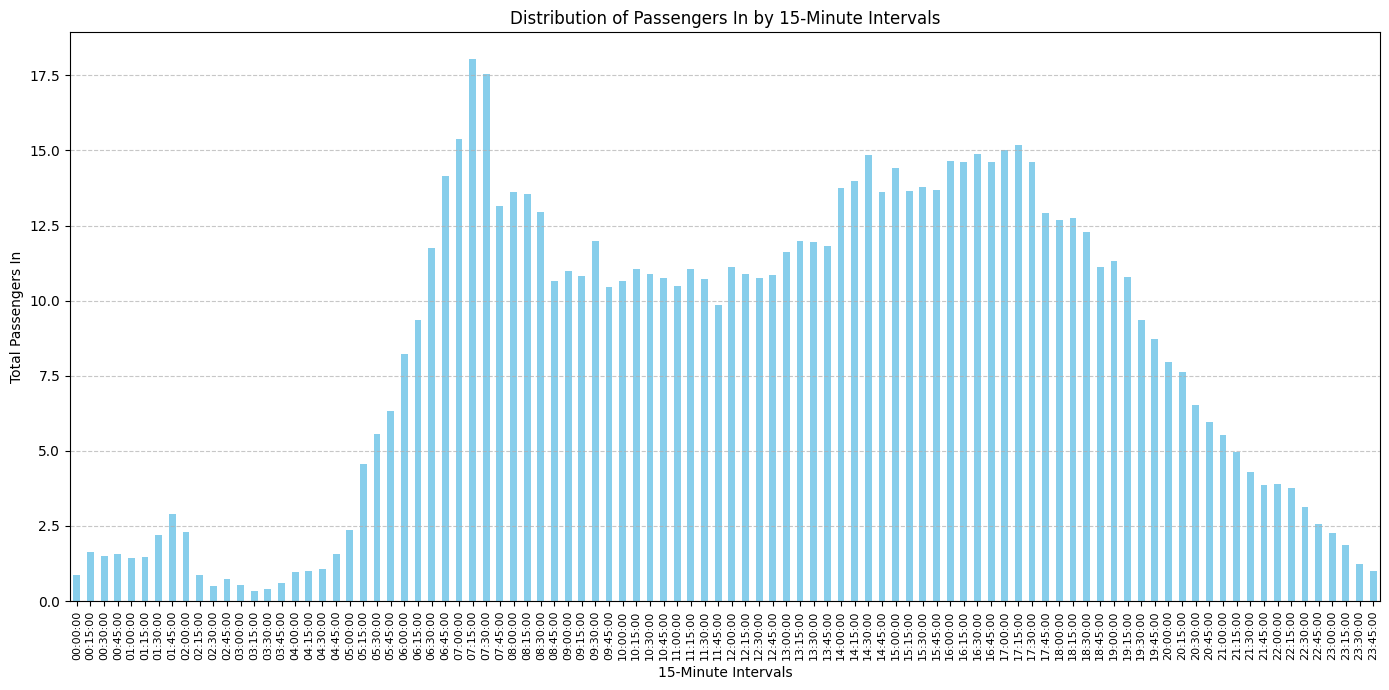

In [108]:
import matplotlib.pyplot as plt
data = x
data = data[data['weekday'] <= 4]
data['15_min_interval'] = data['datetime'].dt.floor('15T').dt.time

interval_distribution_in = data.groupby('15_min_interval')['Relat. fill. [%]'].mean()

plt.figure(figsize=(14, 7))
interval_distribution_in.plot(kind='bar', color='skyblue')
plt.title('Distribution of Passengers In by 15-Minute Intervals')
plt.xlabel('15-Minute Intervals')
plt.ylabel('Total Passengers In')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


So, there are morning peak hours that are from 6:45 to 7:45, so that we can make a discount 50% to those who travel in off peak hours (starting the ride 6:00-6:40AM and 7:40-8:40AM) 

Lovrić, Milan & Raveau, Sebastián & Adnan, Muhammad & Pereira, Francisco & Basak, Kakali & Loganathan, Harish & Ben-Akiva, Moshe. (2016). Evaluating Off-Peak Pricing Strategies in Public Transportation with an Activity-Based Approach. Transportation Research Record Journal of the Transportation Research Board. 2544. 10.3141/2544-02. 

In [ ]:
filtered_df = df_short[
    (df_short['datetime'].dt.weekday < 5) & 
    (
        (df_short['datetime'].dt.time >= pd.Timestamp('06:00').time()) & 
        (df_short['datetime'].dt.time <= pd.Timestamp('06:40').time()) |
        (df_short['datetime'].dt.time >= pd.Timestamp('07:40').time()) & 
        (df_short['datetime'].dt.time <= pd.Timestamp('08:40').time())
    )
]


In [489]:
filtered_out_df = df_short[
    ~(
        (df_short['datetime'].dt.weekday < 5) & 
        (
            (df_short['datetime'].dt.time >= pd.Timestamp('06:00').time()) & 
            (df_short['datetime'].dt.time <= pd.Timestamp('06:40').time()) |
            (df_short['datetime'].dt.time >= pd.Timestamp('07:40').time()) & 
            (df_short['datetime'].dt.time <= pd.Timestamp('08:40').time())
        )
    )
]

In [ ]:
filtered_df['final_price'] = filtered_df['final_price'] / 2

In [493]:
total_money_discount = filtered_out_df['final_price'].sum() * (1 - 0.0229) + filtered_df['final_price'].sum() * 1.0442

In [516]:
total_money_discount

3764206.25772662

In [496]:
total_money / total_money_discount

1.0099706391477195

In [517]:
total_money

3801737.8

In [494]:
total_money_discount

3764206.25772662

# TBD
